In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 10000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/04 11:33:51
episode : 0 | final step : 100 | total reward : 0.0
2020/10/04 11:33:52
episode : 1 | final step : 99 | total reward : -117.0
2020/10/04 11:33:53
episode : 2 | final step : 100 | total reward : 96.0
2020/10/04 11:33:54
episode : 3 | final step : 99 | total reward : -51.0
2020/10/04 11:33:55
episode : 4 | final step : 98 | total reward : -52.0
2020/10/04 11:33:56
episode : 5 | final step : 98 | total reward : -53.0
2020/10/04 11:33:56
episode : 6 | final step : 99 | total reward : 99.0
2020/10/04 11:33:57
episode : 7 | final step : 99 | total reward : -51.0
2020/10/04 11:33:58
episode : 8 | final step : 98 | total reward : -51.0
2020/10/04 11:33:59
episode : 9 | final step : 101 | total reward : 98.0
2020/10/04 11:34:00
episode : 10 | final step : 98 | total reward : -51.0
2020/10/04 11:34:01
episode : 11 | final step : 100 | total reward : -51.0
2020/10/04 11:34:03
episode : 12 | final step : 98 | total reward : -51.0
2020/10/04 11:34:04
episode : 13 | final step : 

2020/10/04 11:35:55
episode : 111 | final step : 98 | total reward : -51.0
2020/10/04 11:35:56
episode : 112 | final step : 98 | total reward : -51.0
2020/10/04 11:35:58
episode : 113 | final step : 98 | total reward : 99.0
2020/10/04 11:35:59
episode : 114 | final step : 98 | total reward : -51.0
2020/10/04 11:36:00
episode : 115 | final step : 100 | total reward : 99.0
2020/10/04 11:36:01
episode : 116 | final step : 99 | total reward : -51.0
2020/10/04 11:36:02
episode : 117 | final step : 97 | total reward : 99.0
2020/10/04 11:36:03
episode : 118 | final step : 98 | total reward : -51.0
2020/10/04 11:36:04
episode : 119 | final step : 96 | total reward : 99.0
2020/10/04 11:36:05
episode : 120 | final step : 98 | total reward : -51.0
2020/10/04 11:36:06
episode : 121 | final step : 97 | total reward : 99.0
2020/10/04 11:36:07
episode : 122 | final step : 98 | total reward : -51.0
2020/10/04 11:36:08
episode : 123 | final step : 98 | total reward : -51.0
2020/10/04 11:36:10
episode :

2020/10/04 11:37:55
episode : 221 | final step : 98 | total reward : -52.0
2020/10/04 11:37:56
episode : 222 | final step : 98 | total reward : 99.0
2020/10/04 11:37:57
episode : 223 | final step : 98 | total reward : 97.0
2020/10/04 11:37:58
episode : 224 | final step : 96 | total reward : 99.0
2020/10/04 11:37:59
episode : 225 | final step : 98 | total reward : -51.0
2020/10/04 11:38:00
episode : 226 | final step : 98 | total reward : -51.0
2020/10/04 11:38:01
episode : 227 | final step : 100 | total reward : 97.0
2020/10/04 11:38:02
episode : 228 | final step : 97 | total reward : 99.0
2020/10/04 11:38:03
episode : 229 | final step : 99 | total reward : -53.0
2020/10/04 11:38:04
episode : 230 | final step : 100 | total reward : 95.0
2020/10/04 11:38:05
episode : 231 | final step : 98 | total reward : -53.0
2020/10/04 11:38:06
episode : 232 | final step : 99 | total reward : 99.0
2020/10/04 11:38:08
episode : 233 | final step : 99 | total reward : -51.0
2020/10/04 11:38:09
episode : 

2020/10/04 11:39:54
episode : 331 | final step : 98 | total reward : -51.0
2020/10/04 11:39:55
episode : 332 | final step : 95 | total reward : 99.0
2020/10/04 11:39:56
episode : 333 | final step : 99 | total reward : 99.0
2020/10/04 11:39:57
episode : 334 | final step : 98 | total reward : -51.0
2020/10/04 11:39:58
episode : 335 | final step : 101 | total reward : 99.0
2020/10/04 11:39:59
episode : 336 | final step : 98 | total reward : -51.0
2020/10/04 11:40:00
episode : 337 | final step : 98 | total reward : -51.0
2020/10/04 11:40:01
episode : 338 | final step : 98 | total reward : -51.0
2020/10/04 11:40:02
episode : 339 | final step : 99 | total reward : -51.0
2020/10/04 11:40:04
episode : 340 | final step : 97 | total reward : 99.0
2020/10/04 11:40:05
episode : 341 | final step : 98 | total reward : -51.0
2020/10/04 11:40:06
episode : 342 | final step : 98 | total reward : 99.0
2020/10/04 11:40:07
episode : 343 | final step : 98 | total reward : -51.0
2020/10/04 11:40:08
episode :

2020/10/04 11:41:51
episode : 441 | final step : 98 | total reward : -51.0
2020/10/04 11:41:52
episode : 442 | final step : 98 | total reward : -51.0
2020/10/04 11:41:54
episode : 443 | final step : 99 | total reward : 99.0
2020/10/04 11:41:55
episode : 444 | final step : 98 | total reward : -51.0
2020/10/04 11:41:56
episode : 445 | final step : 98 | total reward : -51.0
2020/10/04 11:41:57
episode : 446 | final step : 98 | total reward : -51.0
2020/10/04 11:41:58
episode : 447 | final step : 98 | total reward : -51.0
2020/10/04 11:41:59
episode : 448 | final step : 95 | total reward : 99.0
2020/10/04 11:42:00
episode : 449 | final step : 99 | total reward : -51.0
2020/10/04 11:42:01
episode : 450 | final step : 99 | total reward : 99.0
2020/10/04 11:42:02
episode : 451 | final step : 98 | total reward : -51.0
2020/10/04 11:42:04
episode : 452 | final step : 102 | total reward : 99.0
2020/10/04 11:42:05
episode : 453 | final step : 99 | total reward : -51.0
2020/10/04 11:42:06
episode 

2020/10/04 11:43:49
episode : 551 | final step : 97 | total reward : 99.0
2020/10/04 11:43:51
episode : 552 | final step : 100 | total reward : 99.0
2020/10/04 11:43:52
episode : 553 | final step : 98 | total reward : -51.0
2020/10/04 11:43:54
episode : 554 | final step : 99 | total reward : -51.0
2020/10/04 11:43:55
episode : 555 | final step : 99 | total reward : -51.0
2020/10/04 11:43:56
episode : 556 | final step : 98 | total reward : -51.0
2020/10/04 11:43:57
episode : 557 | final step : 98 | total reward : -51.0
2020/10/04 11:43:58
episode : 558 | final step : 98 | total reward : -51.0
2020/10/04 11:43:59
episode : 559 | final step : 98 | total reward : -51.0
2020/10/04 11:44:00
episode : 560 | final step : 98 | total reward : -51.0
2020/10/04 11:44:01
episode : 561 | final step : 98 | total reward : -51.0
2020/10/04 11:44:02
episode : 562 | final step : 99 | total reward : -51.0
2020/10/04 11:44:03
episode : 563 | final step : 97 | total reward : 99.0
2020/10/04 11:44:04
episode

2020/10/04 11:45:48
episode : 661 | final step : 96 | total reward : 99.0
2020/10/04 11:45:49
episode : 662 | final step : 97 | total reward : 99.0
2020/10/04 11:45:51
episode : 663 | final step : 98 | total reward : -51.0
2020/10/04 11:45:52
episode : 664 | final step : 98 | total reward : -51.0
2020/10/04 11:45:53
episode : 665 | final step : 96 | total reward : 99.0
2020/10/04 11:45:54
episode : 666 | final step : 98 | total reward : -51.0
2020/10/04 11:45:55
episode : 667 | final step : 98 | total reward : -51.0
2020/10/04 11:45:56
episode : 668 | final step : 99 | total reward : -51.0
2020/10/04 11:45:57
episode : 669 | final step : 99 | total reward : -51.0
2020/10/04 11:45:58
episode : 670 | final step : 99 | total reward : -51.0
2020/10/04 11:45:59
episode : 671 | final step : 98 | total reward : -51.0
2020/10/04 11:46:00
episode : 672 | final step : 98 | total reward : -51.0
2020/10/04 11:46:01
episode : 673 | final step : 98 | total reward : -51.0
2020/10/04 11:46:02
episode 

2020/10/04 11:47:43
episode : 771 | final step : 98 | total reward : 99.0
2020/10/04 11:47:44
episode : 772 | final step : 98 | total reward : -51.0
2020/10/04 11:47:45
episode : 773 | final step : 98 | total reward : -51.0
2020/10/04 11:47:47
episode : 774 | final step : 99 | total reward : -51.0
2020/10/04 11:47:48
episode : 775 | final step : 98 | total reward : -51.0
2020/10/04 11:47:49
episode : 776 | final step : 99 | total reward : -51.0
2020/10/04 11:47:50
episode : 777 | final step : 98 | total reward : 99.0
2020/10/04 11:47:51
episode : 778 | final step : 98 | total reward : -51.0
2020/10/04 11:47:52
episode : 779 | final step : 100 | total reward : 99.0
2020/10/04 11:47:53
episode : 780 | final step : 98 | total reward : -51.0
2020/10/04 11:47:54
episode : 781 | final step : 99 | total reward : 99.0
2020/10/04 11:47:56
episode : 782 | final step : 101 | total reward : 99.0
2020/10/04 11:47:57
episode : 783 | final step : 98 | total reward : -51.0
2020/10/04 11:47:58
episode 

2020/10/04 11:49:42
episode : 881 | final step : 97 | total reward : 99.0
2020/10/04 11:49:43
episode : 882 | final step : 98 | total reward : -51.0
2020/10/04 11:49:45
episode : 883 | final step : 98 | total reward : -51.0
2020/10/04 11:49:46
episode : 884 | final step : 99 | total reward : 99.0
2020/10/04 11:49:47
episode : 885 | final step : 98 | total reward : 99.0
2020/10/04 11:49:48
episode : 886 | final step : 98 | total reward : 99.0
2020/10/04 11:49:50
episode : 887 | final step : 99 | total reward : -51.0
2020/10/04 11:49:51
episode : 888 | final step : 98 | total reward : -51.0
2020/10/04 11:49:52
episode : 889 | final step : 98 | total reward : -51.0
2020/10/04 11:49:53
episode : 890 | final step : 101 | total reward : 99.0
2020/10/04 11:49:54
episode : 891 | final step : 98 | total reward : 99.0
2020/10/04 11:49:55
episode : 892 | final step : 99 | total reward : -51.0
2020/10/04 11:49:56
episode : 893 | final step : 101 | total reward : 99.0
2020/10/04 11:49:57
episode : 

2020/10/04 11:51:40
episode : 991 | final step : 99 | total reward : -51.0
2020/10/04 11:51:41
episode : 992 | final step : 98 | total reward : -51.0
2020/10/04 11:51:42
episode : 993 | final step : 99 | total reward : -51.0
2020/10/04 11:51:43
episode : 994 | final step : 100 | total reward : 99.0
2020/10/04 11:51:44
episode : 995 | final step : 98 | total reward : -51.0
2020/10/04 11:51:45
episode : 996 | final step : 96 | total reward : 99.0
2020/10/04 11:51:46
episode : 997 | final step : 99 | total reward : 99.0
2020/10/04 11:51:48
episode : 998 | final step : 98 | total reward : -51.0
2020/10/04 11:51:49
episode : 999 | final step : 98 | total reward : 99.0
2020/10/04 11:51:50
episode : 1000 | final step : 98 | total reward : 99.0
2020/10/04 11:51:51
episode : 1001 | final step : 98 | total reward : -51.0
2020/10/04 11:51:52
episode : 1002 | final step : 99 | total reward : 99.0
2020/10/04 11:51:53
episode : 1003 | final step : 98 | total reward : -51.0
2020/10/04 11:51:54
episod

2020/10/04 11:53:39
episode : 1100 | final step : 97 | total reward : -51.0
2020/10/04 11:53:40
episode : 1101 | final step : 99 | total reward : 99.0
2020/10/04 11:53:41
episode : 1102 | final step : 98 | total reward : -51.0
2020/10/04 11:53:42
episode : 1103 | final step : 99 | total reward : -51.0
2020/10/04 11:53:43
episode : 1104 | final step : 98 | total reward : 99.0
2020/10/04 11:53:44
episode : 1105 | final step : 98 | total reward : -51.0
2020/10/04 11:53:45
episode : 1106 | final step : 99 | total reward : 99.0
2020/10/04 11:53:46
episode : 1107 | final step : 98 | total reward : -51.0
2020/10/04 11:53:47
episode : 1108 | final step : 101 | total reward : 99.0
2020/10/04 11:53:48
episode : 1109 | final step : 100 | total reward : 99.0
2020/10/04 11:53:49
episode : 1110 | final step : 99 | total reward : -51.0
2020/10/04 11:53:50
episode : 1111 | final step : 99 | total reward : 99.0
2020/10/04 11:53:51
episode : 1112 | final step : 98 | total reward : -51.0
2020/10/04 11:53

2020/10/04 11:55:36
episode : 1209 | final step : 99 | total reward : 99.0
2020/10/04 11:55:37
episode : 1210 | final step : 98 | total reward : -51.0
2020/10/04 11:55:38
episode : 1211 | final step : 100 | total reward : -51.0
2020/10/04 11:55:39
episode : 1212 | final step : 99 | total reward : -51.0
2020/10/04 11:55:40
episode : 1213 | final step : 98 | total reward : -51.0
2020/10/04 11:55:41
episode : 1214 | final step : 98 | total reward : -51.0
2020/10/04 11:55:42
episode : 1215 | final step : 98 | total reward : -51.0
2020/10/04 11:55:43
episode : 1216 | final step : 98 | total reward : -51.0
2020/10/04 11:55:44
episode : 1217 | final step : 99 | total reward : 99.0
2020/10/04 11:55:45
episode : 1218 | final step : 98 | total reward : -51.0
2020/10/04 11:55:46
episode : 1219 | final step : 99 | total reward : 99.0
2020/10/04 11:55:47
episode : 1220 | final step : 98 | total reward : -51.0
2020/10/04 11:55:48
episode : 1221 | final step : 99 | total reward : -51.0
2020/10/04 11:

2020/10/04 11:57:32
episode : 1318 | final step : 97 | total reward : 99.0
2020/10/04 11:57:33
episode : 1319 | final step : 100 | total reward : -51.0
2020/10/04 11:57:34
episode : 1320 | final step : 98 | total reward : -51.0
2020/10/04 11:57:35
episode : 1321 | final step : 98 | total reward : -51.0
2020/10/04 11:57:36
episode : 1322 | final step : 98 | total reward : -51.0
2020/10/04 11:57:37
episode : 1323 | final step : 98 | total reward : 99.0
2020/10/04 11:57:38
episode : 1324 | final step : 98 | total reward : -51.0
2020/10/04 11:57:39
episode : 1325 | final step : 99 | total reward : -51.0
2020/10/04 11:57:40
episode : 1326 | final step : 98 | total reward : 99.0
2020/10/04 11:57:41
episode : 1327 | final step : 99 | total reward : -51.0
2020/10/04 11:57:42
episode : 1328 | final step : 98 | total reward : -51.0
2020/10/04 11:57:43
episode : 1329 | final step : 98 | total reward : -51.0
2020/10/04 11:57:44
episode : 1330 | final step : 98 | total reward : 99.0
2020/10/04 11:5

2020/10/04 11:59:27
episode : 1427 | final step : 98 | total reward : -51.0
2020/10/04 11:59:28
episode : 1428 | final step : 97 | total reward : 99.0
2020/10/04 11:59:29
episode : 1429 | final step : 98 | total reward : -51.0
2020/10/04 11:59:30
episode : 1430 | final step : 98 | total reward : -51.0
2020/10/04 11:59:31
episode : 1431 | final step : 100 | total reward : 99.0
2020/10/04 11:59:32
episode : 1432 | final step : 97 | total reward : 99.0
2020/10/04 11:59:33
episode : 1433 | final step : 98 | total reward : -51.0
2020/10/04 11:59:34
episode : 1434 | final step : 99 | total reward : 99.0
2020/10/04 11:59:35
episode : 1435 | final step : 97 | total reward : 99.0
2020/10/04 11:59:36
episode : 1436 | final step : 98 | total reward : -51.0
2020/10/04 11:59:37
episode : 1437 | final step : 99 | total reward : -51.0
2020/10/04 11:59:38
episode : 1438 | final step : 98 | total reward : -51.0
2020/10/04 11:59:39
episode : 1439 | final step : 98 | total reward : -51.0
2020/10/04 11:59

2020/10/04 12:01:26
episode : 1536 | final step : 98 | total reward : -51.0
2020/10/04 12:01:28
episode : 1537 | final step : 99 | total reward : -51.0
2020/10/04 12:01:29
episode : 1538 | final step : 94 | total reward : 99.0
2020/10/04 12:01:30
episode : 1539 | final step : 98 | total reward : 99.0
2020/10/04 12:01:31
episode : 1540 | final step : 99 | total reward : -51.0
2020/10/04 12:01:32
episode : 1541 | final step : 98 | total reward : 99.0
2020/10/04 12:01:33
episode : 1542 | final step : 98 | total reward : -51.0
2020/10/04 12:01:34
episode : 1543 | final step : 100 | total reward : 99.0
2020/10/04 12:01:36
episode : 1544 | final step : 99 | total reward : -51.0
2020/10/04 12:01:37
episode : 1545 | final step : 98 | total reward : -51.0
2020/10/04 12:01:38
episode : 1546 | final step : 99 | total reward : -51.0
2020/10/04 12:01:40
episode : 1547 | final step : 99 | total reward : -51.0
2020/10/04 12:01:41
episode : 1548 | final step : 99 | total reward : -51.0
2020/10/04 12:0

2020/10/04 12:03:32
episode : 1645 | final step : 98 | total reward : -51.0
2020/10/04 12:03:34
episode : 1646 | final step : 98 | total reward : -51.0
2020/10/04 12:03:35
episode : 1647 | final step : 99 | total reward : -51.0
2020/10/04 12:03:36
episode : 1648 | final step : 99 | total reward : -51.0
2020/10/04 12:03:37
episode : 1649 | final step : 99 | total reward : -51.0
2020/10/04 12:03:38
episode : 1650 | final step : 100 | total reward : 99.0
2020/10/04 12:03:40
episode : 1651 | final step : 98 | total reward : -51.0
2020/10/04 12:03:41
episode : 1652 | final step : 98 | total reward : -51.0
2020/10/04 12:03:42
episode : 1653 | final step : 101 | total reward : 99.0
2020/10/04 12:03:43
episode : 1654 | final step : 98 | total reward : -51.0
2020/10/04 12:03:45
episode : 1655 | final step : 98 | total reward : -51.0
2020/10/04 12:03:46
episode : 1656 | final step : 96 | total reward : 99.0
2020/10/04 12:03:47
episode : 1657 | final step : 99 | total reward : 99.0
2020/10/04 12:

2020/10/04 12:05:42
episode : 1754 | final step : 98 | total reward : -51.0
2020/10/04 12:05:43
episode : 1755 | final step : 98 | total reward : -51.0
2020/10/04 12:05:44
episode : 1756 | final step : 98 | total reward : -51.0
2020/10/04 12:05:45
episode : 1757 | final step : 100 | total reward : 99.0
2020/10/04 12:05:46
episode : 1758 | final step : 98 | total reward : -51.0
2020/10/04 12:05:47
episode : 1759 | final step : 99 | total reward : 99.0
2020/10/04 12:05:48
episode : 1760 | final step : 100 | total reward : 99.0
2020/10/04 12:05:50
episode : 1761 | final step : 97 | total reward : 99.0
2020/10/04 12:05:51
episode : 1762 | final step : 99 | total reward : -51.0
2020/10/04 12:05:52
episode : 1763 | final step : 99 | total reward : -51.0
2020/10/04 12:05:53
episode : 1764 | final step : 98 | total reward : -51.0
2020/10/04 12:05:55
episode : 1765 | final step : 100 | total reward : 99.0
2020/10/04 12:05:56
episode : 1766 | final step : 98 | total reward : -51.0
2020/10/04 12:

2020/10/04 12:07:46
episode : 1863 | final step : 98 | total reward : -51.0
2020/10/04 12:07:47
episode : 1864 | final step : 102 | total reward : 99.0
2020/10/04 12:07:48
episode : 1865 | final step : 100 | total reward : 99.0
2020/10/04 12:07:50
episode : 1866 | final step : 98 | total reward : -51.0
2020/10/04 12:07:51
episode : 1867 | final step : 99 | total reward : -51.0
2020/10/04 12:07:52
episode : 1868 | final step : 99 | total reward : 99.0
2020/10/04 12:07:53
episode : 1869 | final step : 99 | total reward : -51.0
2020/10/04 12:07:54
episode : 1870 | final step : 100 | total reward : -51.0
2020/10/04 12:07:55
episode : 1871 | final step : 98 | total reward : -51.0
2020/10/04 12:07:57
episode : 1872 | final step : 98 | total reward : -51.0
2020/10/04 12:07:58
episode : 1873 | final step : 98 | total reward : -51.0
2020/10/04 12:07:59
episode : 1874 | final step : 98 | total reward : -51.0
2020/10/04 12:08:00
episode : 1875 | final step : 98 | total reward : -51.0
2020/10/04 1

2020/10/04 12:09:52
episode : 1971 | final step : 99 | total reward : -51.0
2020/10/04 12:09:53
episode : 1972 | final step : 98 | total reward : -51.0
2020/10/04 12:09:54
episode : 1973 | final step : 99 | total reward : 99.0
2020/10/04 12:09:55
episode : 1974 | final step : 99 | total reward : 99.0
2020/10/04 12:09:56
episode : 1975 | final step : 98 | total reward : -51.0
2020/10/04 12:09:58
episode : 1976 | final step : 98 | total reward : -51.0
2020/10/04 12:09:59
episode : 1977 | final step : 98 | total reward : -51.0
2020/10/04 12:10:00
episode : 1978 | final step : 98 | total reward : -51.0
2020/10/04 12:10:01
episode : 1979 | final step : 98 | total reward : -51.0
2020/10/04 12:10:02
episode : 1980 | final step : 100 | total reward : -51.0
2020/10/04 12:10:03
episode : 1981 | final step : 98 | total reward : -51.0
2020/10/04 12:10:04
episode : 1982 | final step : 98 | total reward : 99.0
2020/10/04 12:10:05
episode : 1983 | final step : 99 | total reward : 99.0
2020/10/04 12:1

2020/10/04 12:11:51
episode : 2080 | final step : 98 | total reward : -51.0
2020/10/04 12:11:52
episode : 2081 | final step : 98 | total reward : -51.0
2020/10/04 12:11:53
episode : 2082 | final step : 98 | total reward : -51.0
2020/10/04 12:11:54
episode : 2083 | final step : 98 | total reward : -51.0
2020/10/04 12:11:55
episode : 2084 | final step : 98 | total reward : -51.0
2020/10/04 12:11:56
episode : 2085 | final step : 98 | total reward : -51.0
2020/10/04 12:11:57
episode : 2086 | final step : 98 | total reward : -51.0
2020/10/04 12:11:58
episode : 2087 | final step : 96 | total reward : 99.0
2020/10/04 12:11:59
episode : 2088 | final step : 98 | total reward : 99.0
2020/10/04 12:12:00
episode : 2089 | final step : 98 | total reward : -51.0
2020/10/04 12:12:01
episode : 2090 | final step : 98 | total reward : -51.0
2020/10/04 12:12:02
episode : 2091 | final step : 98 | total reward : -52.0
2020/10/04 12:12:03
episode : 2092 | final step : 98 | total reward : -51.0
2020/10/04 12:

2020/10/04 12:13:53
episode : 2189 | final step : 98 | total reward : 99.0
2020/10/04 12:13:55
episode : 2190 | final step : 99 | total reward : -51.0
2020/10/04 12:13:56
episode : 2191 | final step : 98 | total reward : -51.0
2020/10/04 12:13:57
episode : 2192 | final step : 99 | total reward : -51.0
2020/10/04 12:13:58
episode : 2193 | final step : 98 | total reward : 99.0
2020/10/04 12:13:59
episode : 2194 | final step : 98 | total reward : -51.0
2020/10/04 12:14:00
episode : 2195 | final step : 98 | total reward : -51.0
2020/10/04 12:14:01
episode : 2196 | final step : 98 | total reward : -51.0
2020/10/04 12:14:02
episode : 2197 | final step : 98 | total reward : 99.0
2020/10/04 12:14:04
episode : 2198 | final step : 100 | total reward : 99.0
2020/10/04 12:14:05
episode : 2199 | final step : 97 | total reward : 99.0
2020/10/04 12:14:06
episode : 2200 | final step : 98 | total reward : 99.0
2020/10/04 12:14:07
episode : 2201 | final step : 98 | total reward : -51.0
2020/10/04 12:14:

2020/10/04 12:15:57
episode : 2298 | final step : 97 | total reward : 99.0
2020/10/04 12:15:58
episode : 2299 | final step : 95 | total reward : 99.0
2020/10/04 12:15:59
episode : 2300 | final step : 98 | total reward : 99.0
2020/10/04 12:16:01
episode : 2301 | final step : 98 | total reward : 99.0
2020/10/04 12:16:02
episode : 2302 | final step : 98 | total reward : -51.0
2020/10/04 12:16:03
episode : 2303 | final step : 102 | total reward : 99.0
2020/10/04 12:16:04
episode : 2304 | final step : 97 | total reward : 99.0
2020/10/04 12:16:05
episode : 2305 | final step : 98 | total reward : -51.0
2020/10/04 12:16:06
episode : 2306 | final step : 98 | total reward : -51.0
2020/10/04 12:16:07
episode : 2307 | final step : 98 | total reward : -51.0
2020/10/04 12:16:08
episode : 2308 | final step : 97 | total reward : 99.0
2020/10/04 12:16:10
episode : 2309 | final step : 98 | total reward : -51.0
2020/10/04 12:16:11
episode : 2310 | final step : 100 | total reward : 99.0
2020/10/04 12:16:1

2020/10/04 12:18:02
episode : 2407 | final step : 98 | total reward : -51.0
2020/10/04 12:18:03
episode : 2408 | final step : 103 | total reward : 99.0
2020/10/04 12:18:04
episode : 2409 | final step : 98 | total reward : -51.0
2020/10/04 12:18:06
episode : 2410 | final step : 99 | total reward : -51.0
2020/10/04 12:18:07
episode : 2411 | final step : 98 | total reward : -51.0
2020/10/04 12:18:08
episode : 2412 | final step : 98 | total reward : -51.0
2020/10/04 12:18:09
episode : 2413 | final step : 99 | total reward : -51.0
2020/10/04 12:18:10
episode : 2414 | final step : 97 | total reward : -51.0
2020/10/04 12:18:11
episode : 2415 | final step : 99 | total reward : 99.0
2020/10/04 12:18:12
episode : 2416 | final step : 98 | total reward : -51.0
2020/10/04 12:18:13
episode : 2417 | final step : 98 | total reward : -51.0
2020/10/04 12:18:14
episode : 2418 | final step : 96 | total reward : 99.0
2020/10/04 12:18:16
episode : 2419 | final step : 97 | total reward : 99.0
2020/10/04 12:1

2020/10/04 12:19:57
episode : 2515 | final step : 98 | total reward : -51.0
2020/10/04 12:19:58
episode : 2516 | final step : 95 | total reward : 98.0
2020/10/04 12:19:59
episode : 2517 | final step : 99 | total reward : 99.0
2020/10/04 12:20:00
episode : 2518 | final step : 98 | total reward : -51.0
2020/10/04 12:20:01
episode : 2519 | final step : 98 | total reward : -51.0
2020/10/04 12:20:02
episode : 2520 | final step : 98 | total reward : -51.0
2020/10/04 12:20:03
episode : 2521 | final step : 100 | total reward : -51.0
2020/10/04 12:20:04
episode : 2522 | final step : 98 | total reward : -51.0
2020/10/04 12:20:05
episode : 2523 | final step : 98 | total reward : -51.0
2020/10/04 12:20:06
episode : 2524 | final step : 99 | total reward : -51.0
2020/10/04 12:20:07
episode : 2525 | final step : 98 | total reward : -51.0
2020/10/04 12:20:08
episode : 2526 | final step : 98 | total reward : -52.0
2020/10/04 12:20:09
episode : 2527 | final step : 100 | total reward : 99.0
2020/10/04 12

2020/10/04 12:21:53
episode : 2624 | final step : 99 | total reward : 99.0
2020/10/04 12:21:54
episode : 2625 | final step : 98 | total reward : -51.0
2020/10/04 12:21:55
episode : 2626 | final step : 98 | total reward : -51.0
2020/10/04 12:21:56
episode : 2627 | final step : 98 | total reward : -51.0
2020/10/04 12:21:57
episode : 2628 | final step : 98 | total reward : -51.0
2020/10/04 12:21:58
episode : 2629 | final step : 98 | total reward : 99.0
2020/10/04 12:21:59
episode : 2630 | final step : 98 | total reward : -51.0
2020/10/04 12:22:00
episode : 2631 | final step : 98 | total reward : -51.0
2020/10/04 12:22:01
episode : 2632 | final step : 98 | total reward : -51.0
2020/10/04 12:22:02
episode : 2633 | final step : 98 | total reward : -51.0
2020/10/04 12:22:03
episode : 2634 | final step : 101 | total reward : 99.0
2020/10/04 12:22:04
episode : 2635 | final step : 97 | total reward : 99.0
2020/10/04 12:22:05
episode : 2636 | final step : 100 | total reward : 99.0
2020/10/04 12:2

2020/10/04 12:23:49
episode : 2733 | final step : 99 | total reward : 99.0
2020/10/04 12:23:50
episode : 2734 | final step : 99 | total reward : -51.0
2020/10/04 12:23:51
episode : 2735 | final step : 99 | total reward : -51.0
2020/10/04 12:23:52
episode : 2736 | final step : 98 | total reward : 99.0
2020/10/04 12:23:53
episode : 2737 | final step : 98 | total reward : -51.0
2020/10/04 12:23:54
episode : 2738 | final step : 100 | total reward : 99.0
2020/10/04 12:23:55
episode : 2739 | final step : 98 | total reward : -51.0
2020/10/04 12:23:56
episode : 2740 | final step : 98 | total reward : 99.0
2020/10/04 12:23:58
episode : 2741 | final step : 99 | total reward : -51.0
2020/10/04 12:23:59
episode : 2742 | final step : 100 | total reward : 98.0
2020/10/04 12:24:00
episode : 2743 | final step : 98 | total reward : -51.0
2020/10/04 12:24:01
episode : 2744 | final step : 98 | total reward : -51.0
2020/10/04 12:24:02
episode : 2745 | final step : 101 | total reward : 99.0
2020/10/04 12:2

2020/10/04 12:25:50
episode : 2842 | final step : 98 | total reward : 99.0
2020/10/04 12:25:51
episode : 2843 | final step : 96 | total reward : 99.0
2020/10/04 12:25:52
episode : 2844 | final step : 98 | total reward : 99.0
2020/10/04 12:25:53
episode : 2845 | final step : 98 | total reward : -51.0
2020/10/04 12:25:54
episode : 2846 | final step : 98 | total reward : -51.0
2020/10/04 12:25:55
episode : 2847 | final step : 96 | total reward : 99.0
2020/10/04 12:25:56
episode : 2848 | final step : 97 | total reward : 99.0
2020/10/04 12:25:57
episode : 2849 | final step : 98 | total reward : -51.0
2020/10/04 12:25:58
episode : 2850 | final step : 98 | total reward : -51.0
2020/10/04 12:25:59
episode : 2851 | final step : 98 | total reward : -51.0
2020/10/04 12:26:00
episode : 2852 | final step : 98 | total reward : -51.0
2020/10/04 12:26:01
episode : 2853 | final step : 99 | total reward : -51.0
2020/10/04 12:26:02
episode : 2854 | final step : 99 | total reward : -51.0
2020/10/04 12:26:

2020/10/04 12:27:50
episode : 2951 | final step : 99 | total reward : -51.0
2020/10/04 12:27:51
episode : 2952 | final step : 99 | total reward : -51.0
2020/10/04 12:27:53
episode : 2953 | final step : 98 | total reward : -51.0
2020/10/04 12:27:54
episode : 2954 | final step : 99 | total reward : 99.0
2020/10/04 12:27:55
episode : 2955 | final step : 96 | total reward : 99.0
2020/10/04 12:27:56
episode : 2956 | final step : 98 | total reward : 99.0
2020/10/04 12:27:57
episode : 2957 | final step : 99 | total reward : -51.0
2020/10/04 12:27:58
episode : 2958 | final step : 98 | total reward : -51.0
2020/10/04 12:27:59
episode : 2959 | final step : 98 | total reward : 99.0
2020/10/04 12:28:01
episode : 2960 | final step : 99 | total reward : -51.0
2020/10/04 12:28:02
episode : 2961 | final step : 97 | total reward : 99.0
2020/10/04 12:28:03
episode : 2962 | final step : 96 | total reward : 99.0
2020/10/04 12:28:04
episode : 2963 | final step : 98 | total reward : -51.0
2020/10/04 12:28:0

2020/10/04 12:29:57
episode : 3060 | final step : 98 | total reward : -51.0
2020/10/04 12:29:58
episode : 3061 | final step : 98 | total reward : -51.0
2020/10/04 12:29:59
episode : 3062 | final step : 98 | total reward : -51.0
2020/10/04 12:30:00
episode : 3063 | final step : 97 | total reward : 99.0
2020/10/04 12:30:02
episode : 3064 | final step : 98 | total reward : -51.0
2020/10/04 12:30:02
episode : 3065 | final step : 98 | total reward : -51.0
2020/10/04 12:30:04
episode : 3066 | final step : 100 | total reward : 99.0
2020/10/04 12:30:05
episode : 3067 | final step : 98 | total reward : -51.0
2020/10/04 12:30:06
episode : 3068 | final step : 99 | total reward : 99.0
2020/10/04 12:30:07
episode : 3069 | final step : 98 | total reward : -51.0
2020/10/04 12:30:09
episode : 3070 | final step : 98 | total reward : -51.0
2020/10/04 12:30:10
episode : 3071 | final step : 98 | total reward : -51.0
2020/10/04 12:30:11
episode : 3072 | final step : 98 | total reward : -51.0
2020/10/04 12:

2020/10/04 12:31:55
episode : 3169 | final step : 98 | total reward : -51.0
2020/10/04 12:31:56
episode : 3170 | final step : 98 | total reward : -51.0
2020/10/04 12:31:58
episode : 3171 | final step : 98 | total reward : -51.0
2020/10/04 12:31:59
episode : 3172 | final step : 99 | total reward : -51.0
2020/10/04 12:32:00
episode : 3173 | final step : 99 | total reward : -51.0
2020/10/04 12:32:01
episode : 3174 | final step : 97 | total reward : -51.0
2020/10/04 12:32:02
episode : 3175 | final step : 99 | total reward : -51.0
2020/10/04 12:32:03
episode : 3176 | final step : 98 | total reward : -51.0
2020/10/04 12:32:04
episode : 3177 | final step : 100 | total reward : 99.0
2020/10/04 12:32:05
episode : 3178 | final step : 97 | total reward : 99.0
2020/10/04 12:32:06
episode : 3179 | final step : 97 | total reward : 99.0
2020/10/04 12:32:07
episode : 3180 | final step : 98 | total reward : -51.0
2020/10/04 12:32:08
episode : 3181 | final step : 99 | total reward : -51.0
2020/10/04 12:

2020/10/04 12:33:54
episode : 3278 | final step : 98 | total reward : -51.0
2020/10/04 12:33:55
episode : 3279 | final step : 98 | total reward : -51.0
2020/10/04 12:33:56
episode : 3280 | final step : 98 | total reward : -51.0
2020/10/04 12:33:57
episode : 3281 | final step : 98 | total reward : -51.0
2020/10/04 12:33:58
episode : 3282 | final step : 98 | total reward : -51.0
2020/10/04 12:33:59
episode : 3283 | final step : 98 | total reward : -51.0
2020/10/04 12:34:00
episode : 3284 | final step : 98 | total reward : -51.0
2020/10/04 12:34:01
episode : 3285 | final step : 98 | total reward : -51.0
2020/10/04 12:34:02
episode : 3286 | final step : 99 | total reward : -51.0
2020/10/04 12:34:03
episode : 3287 | final step : 99 | total reward : -51.0
2020/10/04 12:34:04
episode : 3288 | final step : 98 | total reward : 99.0
2020/10/04 12:34:05
episode : 3289 | final step : 99 | total reward : -51.0
2020/10/04 12:34:06
episode : 3290 | final step : 98 | total reward : -51.0
2020/10/04 12

2020/10/04 12:35:49
episode : 3387 | final step : 97 | total reward : 99.0
2020/10/04 12:35:51
episode : 3388 | final step : 99 | total reward : -51.0
2020/10/04 12:35:52
episode : 3389 | final step : 98 | total reward : -51.0
2020/10/04 12:35:53
episode : 3390 | final step : 98 | total reward : -51.0
2020/10/04 12:35:54
episode : 3391 | final step : 99 | total reward : -51.0
2020/10/04 12:35:55
episode : 3392 | final step : 98 | total reward : -51.0
2020/10/04 12:35:56
episode : 3393 | final step : 97 | total reward : 99.0
2020/10/04 12:35:57
episode : 3394 | final step : 96 | total reward : 99.0
2020/10/04 12:35:58
episode : 3395 | final step : 98 | total reward : -51.0
2020/10/04 12:35:59
episode : 3396 | final step : 98 | total reward : 99.0
2020/10/04 12:36:00
episode : 3397 | final step : 97 | total reward : -51.0
2020/10/04 12:36:01
episode : 3398 | final step : 96 | total reward : 99.0
2020/10/04 12:36:02
episode : 3399 | final step : 98 | total reward : -51.0
2020/10/04 12:36:

2020/10/04 12:37:47
episode : 3496 | final step : 99 | total reward : -51.0
2020/10/04 12:37:48
episode : 3497 | final step : 98 | total reward : -51.0
2020/10/04 12:37:49
episode : 3498 | final step : 99 | total reward : -51.0
2020/10/04 12:37:50
episode : 3499 | final step : 100 | total reward : 99.0
2020/10/04 12:37:51
episode : 3500 | final step : 97 | total reward : 99.0
2020/10/04 12:37:52
episode : 3501 | final step : 98 | total reward : -51.0
2020/10/04 12:37:53
episode : 3502 | final step : 98 | total reward : -51.0
2020/10/04 12:37:54
episode : 3503 | final step : 100 | total reward : -51.0
2020/10/04 12:37:55
episode : 3504 | final step : 99 | total reward : -51.0
2020/10/04 12:37:56
episode : 3505 | final step : 99 | total reward : -51.0
2020/10/04 12:37:57
episode : 3506 | final step : 99 | total reward : 99.0
2020/10/04 12:37:58
episode : 3507 | final step : 99 | total reward : -51.0
2020/10/04 12:37:59
episode : 3508 | final step : 101 | total reward : 99.0
2020/10/04 12

2020/10/04 12:39:47
episode : 3605 | final step : 98 | total reward : -51.0
2020/10/04 12:39:48
episode : 3606 | final step : 98 | total reward : -51.0
2020/10/04 12:39:49
episode : 3607 | final step : 97 | total reward : 99.0
2020/10/04 12:39:50
episode : 3608 | final step : 99 | total reward : -51.0
2020/10/04 12:39:51
episode : 3609 | final step : 97 | total reward : 99.0
2020/10/04 12:39:52
episode : 3610 | final step : 98 | total reward : -51.0
2020/10/04 12:39:53
episode : 3611 | final step : 98 | total reward : -51.0
2020/10/04 12:39:54
episode : 3612 | final step : 98 | total reward : -51.0
2020/10/04 12:39:55
episode : 3613 | final step : 96 | total reward : 99.0
2020/10/04 12:39:56
episode : 3614 | final step : 98 | total reward : -51.0
2020/10/04 12:39:57
episode : 3615 | final step : 98 | total reward : -51.0
2020/10/04 12:39:58
episode : 3616 | final step : 98 | total reward : -51.0
2020/10/04 12:39:59
episode : 3617 | final step : 94 | total reward : 99.0
2020/10/04 12:40

2020/10/04 12:41:42
episode : 3714 | final step : 98 | total reward : -51.0
2020/10/04 12:41:43
episode : 3715 | final step : 99 | total reward : -51.0
2020/10/04 12:41:44
episode : 3716 | final step : 97 | total reward : 99.0
2020/10/04 12:41:46
episode : 3717 | final step : 100 | total reward : 99.0
2020/10/04 12:41:47
episode : 3718 | final step : 98 | total reward : -51.0
2020/10/04 12:41:48
episode : 3719 | final step : 98 | total reward : -51.0
2020/10/04 12:41:49
episode : 3720 | final step : 99 | total reward : -51.0
2020/10/04 12:41:50
episode : 3721 | final step : 99 | total reward : -51.0
2020/10/04 12:41:51
episode : 3722 | final step : 100 | total reward : 99.0
2020/10/04 12:41:52
episode : 3723 | final step : 98 | total reward : -51.0
2020/10/04 12:41:53
episode : 3724 | final step : 98 | total reward : -51.0
2020/10/04 12:41:55
episode : 3725 | final step : 99 | total reward : -51.0
2020/10/04 12:41:56
episode : 3726 | final step : 99 | total reward : -51.0
2020/10/04 12

2020/10/04 12:43:42
episode : 3823 | final step : 99 | total reward : -51.0
2020/10/04 12:43:43
episode : 3824 | final step : 98 | total reward : -51.0
2020/10/04 12:43:45
episode : 3825 | final step : 98 | total reward : -51.0
2020/10/04 12:43:46
episode : 3826 | final step : 98 | total reward : -51.0
2020/10/04 12:43:47
episode : 3827 | final step : 98 | total reward : -51.0
2020/10/04 12:43:48
episode : 3828 | final step : 100 | total reward : 99.0
2020/10/04 12:43:49
episode : 3829 | final step : 99 | total reward : 99.0
2020/10/04 12:43:50
episode : 3830 | final step : 99 | total reward : 99.0
2020/10/04 12:43:51
episode : 3831 | final step : 98 | total reward : -51.0
2020/10/04 12:43:52
episode : 3832 | final step : 99 | total reward : 99.0
2020/10/04 12:43:53
episode : 3833 | final step : 99 | total reward : -51.0
2020/10/04 12:43:55
episode : 3834 | final step : 99 | total reward : -51.0
2020/10/04 12:43:56
episode : 3835 | final step : 98 | total reward : -51.0
2020/10/04 12:4

2020/10/04 12:45:47
episode : 3932 | final step : 98 | total reward : 99.0
2020/10/04 12:45:49
episode : 3933 | final step : 99 | total reward : -51.0
2020/10/04 12:45:50
episode : 3934 | final step : 99 | total reward : 99.0
2020/10/04 12:45:51
episode : 3935 | final step : 98 | total reward : -51.0
2020/10/04 12:45:52
episode : 3936 | final step : 99 | total reward : 99.0
2020/10/04 12:45:53
episode : 3937 | final step : 98 | total reward : -51.0
2020/10/04 12:45:54
episode : 3938 | final step : 99 | total reward : -51.0
2020/10/04 12:45:55
episode : 3939 | final step : 98 | total reward : 99.0
2020/10/04 12:45:56
episode : 3940 | final step : 99 | total reward : -51.0
2020/10/04 12:45:57
episode : 3941 | final step : 95 | total reward : 99.0
2020/10/04 12:45:58
episode : 3942 | final step : 96 | total reward : 99.0
2020/10/04 12:45:59
episode : 3943 | final step : 99 | total reward : -51.0
2020/10/04 12:46:00
episode : 3944 | final step : 98 | total reward : 99.0
2020/10/04 12:46:01

2020/10/04 12:47:54
episode : 4041 | final step : 98 | total reward : -51.0
2020/10/04 12:47:55
episode : 4042 | final step : 100 | total reward : -51.0
2020/10/04 12:47:56
episode : 4043 | final step : 98 | total reward : -51.0
2020/10/04 12:47:57
episode : 4044 | final step : 100 | total reward : -51.0
2020/10/04 12:47:58
episode : 4045 | final step : 98 | total reward : -51.0
2020/10/04 12:48:00
episode : 4046 | final step : 98 | total reward : -51.0
2020/10/04 12:48:01
episode : 4047 | final step : 97 | total reward : 99.0
2020/10/04 12:48:02
episode : 4048 | final step : 99 | total reward : -51.0
2020/10/04 12:48:03
episode : 4049 | final step : 98 | total reward : -51.0
2020/10/04 12:48:04
episode : 4050 | final step : 98 | total reward : -51.0
2020/10/04 12:48:05
episode : 4051 | final step : 100 | total reward : 99.0
2020/10/04 12:48:06
episode : 4052 | final step : 98 | total reward : 99.0
2020/10/04 12:48:08
episode : 4053 | final step : 98 | total reward : -51.0
2020/10/04 1

2020/10/04 12:50:01
episode : 4150 | final step : 98 | total reward : -51.0
2020/10/04 12:50:02
episode : 4151 | final step : 99 | total reward : -51.0
2020/10/04 12:50:03
episode : 4152 | final step : 100 | total reward : 99.0
2020/10/04 12:50:04
episode : 4153 | final step : 100 | total reward : -51.0
2020/10/04 12:50:06
episode : 4154 | final step : 99 | total reward : -51.0
2020/10/04 12:50:07
episode : 4155 | final step : 98 | total reward : -51.0
2020/10/04 12:50:08
episode : 4156 | final step : 99 | total reward : -51.0
2020/10/04 12:50:10
episode : 4157 | final step : 98 | total reward : -51.0
2020/10/04 12:50:11
episode : 4158 | final step : 97 | total reward : 99.0
2020/10/04 12:50:12
episode : 4159 | final step : 98 | total reward : -51.0
2020/10/04 12:50:13
episode : 4160 | final step : 97 | total reward : 99.0
2020/10/04 12:50:14
episode : 4161 | final step : 98 | total reward : -51.0
2020/10/04 12:50:15
episode : 4162 | final step : 100 | total reward : 99.0
2020/10/04 12

2020/10/04 12:52:04
episode : 4258 | final step : 98 | total reward : -51.0
2020/10/04 12:52:05
episode : 4259 | final step : 94 | total reward : 99.0
2020/10/04 12:52:06
episode : 4260 | final step : 99 | total reward : -51.0
2020/10/04 12:52:07
episode : 4261 | final step : 99 | total reward : 99.0
2020/10/04 12:52:08
episode : 4262 | final step : 97 | total reward : 99.0
2020/10/04 12:52:09
episode : 4263 | final step : 99 | total reward : -51.0
2020/10/04 12:52:10
episode : 4264 | final step : 101 | total reward : 99.0
2020/10/04 12:52:11
episode : 4265 | final step : 98 | total reward : -51.0
2020/10/04 12:52:12
episode : 4266 | final step : 96 | total reward : 99.0
2020/10/04 12:52:13
episode : 4267 | final step : 99 | total reward : -51.0
2020/10/04 12:52:14
episode : 4268 | final step : 99 | total reward : -51.0
2020/10/04 12:52:15
episode : 4269 | final step : 98 | total reward : -51.0
2020/10/04 12:52:16
episode : 4270 | final step : 100 | total reward : -51.0
2020/10/04 12:5

2020/10/04 12:54:00
episode : 4367 | final step : 98 | total reward : -51.0
2020/10/04 12:54:02
episode : 4368 | final step : 98 | total reward : -51.0
2020/10/04 12:54:03
episode : 4369 | final step : 98 | total reward : -51.0
2020/10/04 12:54:04
episode : 4370 | final step : 97 | total reward : 99.0
2020/10/04 12:54:05
episode : 4371 | final step : 100 | total reward : 99.0
2020/10/04 12:54:07
episode : 4372 | final step : 99 | total reward : -51.0
2020/10/04 12:54:08
episode : 4373 | final step : 98 | total reward : 99.0
2020/10/04 12:54:09
episode : 4374 | final step : 98 | total reward : -51.0
2020/10/04 12:54:10
episode : 4375 | final step : 99 | total reward : -51.0
2020/10/04 12:54:11
episode : 4376 | final step : 99 | total reward : 99.0
2020/10/04 12:54:13
episode : 4377 | final step : 99 | total reward : -51.0
2020/10/04 12:54:14
episode : 4378 | final step : 98 | total reward : -51.0
2020/10/04 12:54:15
episode : 4379 | final step : 98 | total reward : -51.0
2020/10/04 12:5

2020/10/04 12:56:11
episode : 4476 | final step : 97 | total reward : 99.0
2020/10/04 12:56:12
episode : 4477 | final step : 98 | total reward : -51.0
2020/10/04 12:56:14
episode : 4478 | final step : 98 | total reward : -51.0
2020/10/04 12:56:15
episode : 4479 | final step : 97 | total reward : 99.0
2020/10/04 12:56:16
episode : 4480 | final step : 98 | total reward : -51.0
2020/10/04 12:56:17
episode : 4481 | final step : 98 | total reward : -51.0
2020/10/04 12:56:18
episode : 4482 | final step : 101 | total reward : 99.0
2020/10/04 12:56:20
episode : 4483 | final step : 97 | total reward : 99.0
2020/10/04 12:56:21
episode : 4484 | final step : 98 | total reward : -51.0
2020/10/04 12:56:22
episode : 4485 | final step : 99 | total reward : -51.0
2020/10/04 12:56:23
episode : 4486 | final step : 98 | total reward : -51.0
2020/10/04 12:56:24
episode : 4487 | final step : 100 | total reward : -51.0
2020/10/04 12:56:26
episode : 4488 | final step : 98 | total reward : -51.0
2020/10/04 12:

2020/10/04 12:58:17
episode : 4585 | final step : 98 | total reward : 99.0
2020/10/04 12:58:18
episode : 4586 | final step : 98 | total reward : -51.0
2020/10/04 12:58:19
episode : 4587 | final step : 99 | total reward : -51.0
2020/10/04 12:58:20
episode : 4588 | final step : 99 | total reward : -51.0
2020/10/04 12:58:21
episode : 4589 | final step : 98 | total reward : -51.0
2020/10/04 12:58:22
episode : 4590 | final step : 99 | total reward : 99.0
2020/10/04 12:58:23
episode : 4591 | final step : 99 | total reward : 99.0
2020/10/04 12:58:24
episode : 4592 | final step : 98 | total reward : -51.0
2020/10/04 12:58:25
episode : 4593 | final step : 97 | total reward : 99.0
2020/10/04 12:58:26
episode : 4594 | final step : 98 | total reward : -51.0
2020/10/04 12:58:27
episode : 4595 | final step : 98 | total reward : -51.0
2020/10/04 12:58:28
episode : 4596 | final step : 99 | total reward : -51.0
2020/10/04 12:58:30
episode : 4597 | final step : 99 | total reward : -51.0
2020/10/04 12:58

2020/10/04 13:00:22
episode : 4693 | final step : 98 | total reward : -50.0
2020/10/04 13:00:23
episode : 4694 | final step : 101 | total reward : 100.0
2020/10/04 13:00:24
episode : 4695 | final step : 98 | total reward : -50.0
2020/10/04 13:00:26
episode : 4696 | final step : 96 | total reward : 100.0
2020/10/04 13:00:27
episode : 4697 | final step : 99 | total reward : -50.0
2020/10/04 13:00:28
episode : 4698 | final step : 98 | total reward : -50.0
2020/10/04 13:00:29
episode : 4699 | final step : 101 | total reward : 100.0
2020/10/04 13:00:30
episode : 4700 | final step : 98 | total reward : -50.0
2020/10/04 13:00:31
episode : 4701 | final step : 100 | total reward : 100.0
2020/10/04 13:00:33
episode : 4702 | final step : 102 | total reward : 100.0
2020/10/04 13:00:34
episode : 4703 | final step : 100 | total reward : 100.0
2020/10/04 13:00:35
episode : 4704 | final step : 98 | total reward : -50.0
2020/10/04 13:00:36
episode : 4705 | final step : 98 | total reward : -50.0
2020/10

2020/10/04 13:02:32
episode : 4801 | final step : 98 | total reward : -50.0
2020/10/04 13:02:33
episode : 4802 | final step : 98 | total reward : -50.0
2020/10/04 13:02:34
episode : 4803 | final step : 98 | total reward : -50.0
2020/10/04 13:02:35
episode : 4804 | final step : 98 | total reward : -50.0
2020/10/04 13:02:36
episode : 4805 | final step : 98 | total reward : 100.0
2020/10/04 13:02:38
episode : 4806 | final step : 97 | total reward : 100.0
2020/10/04 13:02:39
episode : 4807 | final step : 99 | total reward : -50.0
2020/10/04 13:02:40
episode : 4808 | final step : 98 | total reward : -50.0
2020/10/04 13:02:41
episode : 4809 | final step : 98 | total reward : -50.0
2020/10/04 13:02:42
episode : 4810 | final step : 98 | total reward : 100.0
2020/10/04 13:02:43
episode : 4811 | final step : 98 | total reward : 100.0
2020/10/04 13:02:44
episode : 4812 | final step : 99 | total reward : 100.0
2020/10/04 13:02:46
episode : 4813 | final step : 98 | total reward : -50.0
2020/10/04 1

2020/10/04 13:04:39
episode : 4909 | final step : 99 | total reward : -50.0
2020/10/04 13:04:40
episode : 4910 | final step : 98 | total reward : -50.0
2020/10/04 13:04:42
episode : 4911 | final step : 99 | total reward : -50.0
2020/10/04 13:04:43
episode : 4912 | final step : 98 | total reward : -50.0
2020/10/04 13:04:44
episode : 4913 | final step : 97 | total reward : 100.0
2020/10/04 13:04:45
episode : 4914 | final step : 98 | total reward : -50.0
2020/10/04 13:04:46
episode : 4915 | final step : 97 | total reward : 100.0
2020/10/04 13:04:47
episode : 4916 | final step : 98 | total reward : -50.0
2020/10/04 13:04:48
episode : 4917 | final step : 98 | total reward : -50.0
2020/10/04 13:04:49
episode : 4918 | final step : 99 | total reward : -50.0
2020/10/04 13:04:50
episode : 4919 | final step : 99 | total reward : -50.0
2020/10/04 13:04:51
episode : 4920 | final step : 99 | total reward : 100.0
2020/10/04 13:04:52
episode : 4921 | final step : 100 | total reward : 100.0
2020/10/04 

2020/10/04 13:06:38
episode : 5017 | final step : 99 | total reward : -50.0
2020/10/04 13:06:39
episode : 5018 | final step : 97 | total reward : 100.0
2020/10/04 13:06:41
episode : 5019 | final step : 101 | total reward : 100.0
2020/10/04 13:06:42
episode : 5020 | final step : 98 | total reward : -50.0
2020/10/04 13:06:43
episode : 5021 | final step : 98 | total reward : -50.0
2020/10/04 13:06:44
episode : 5022 | final step : 100 | total reward : 100.0
2020/10/04 13:06:45
episode : 5023 | final step : 98 | total reward : -50.0
2020/10/04 13:06:46
episode : 5024 | final step : 98 | total reward : -50.0
2020/10/04 13:06:47
episode : 5025 | final step : 100 | total reward : 100.0
2020/10/04 13:06:48
episode : 5026 | final step : 98 | total reward : -50.0
2020/10/04 13:06:49
episode : 5027 | final step : 98 | total reward : -50.0
2020/10/04 13:06:50
episode : 5028 | final step : 97 | total reward : -50.0
2020/10/04 13:06:51
episode : 5029 | final step : 98 | total reward : -50.0
2020/10/0

2020/10/04 13:08:36
episode : 5125 | final step : 98 | total reward : -50.0
2020/10/04 13:08:37
episode : 5126 | final step : 98 | total reward : -50.0
2020/10/04 13:08:38
episode : 5127 | final step : 98 | total reward : -50.0
2020/10/04 13:08:39
episode : 5128 | final step : 99 | total reward : 100.0
2020/10/04 13:08:40
episode : 5129 | final step : 98 | total reward : -50.0
2020/10/04 13:08:41
episode : 5130 | final step : 98 | total reward : -50.0
2020/10/04 13:08:43
episode : 5131 | final step : 99 | total reward : -50.0
2020/10/04 13:08:44
episode : 5132 | final step : 100 | total reward : 100.0
2020/10/04 13:08:45
episode : 5133 | final step : 98 | total reward : -50.0
2020/10/04 13:08:46
episode : 5134 | final step : 98 | total reward : -50.0
2020/10/04 13:08:47
episode : 5135 | final step : 98 | total reward : -50.0
2020/10/04 13:08:48
episode : 5136 | final step : 98 | total reward : -50.0
2020/10/04 13:08:49
episode : 5137 | final step : 98 | total reward : 100.0
2020/10/04 

2020/10/04 13:10:35
episode : 5233 | final step : 98 | total reward : 100.0
2020/10/04 13:10:36
episode : 5234 | final step : 99 | total reward : -50.0
2020/10/04 13:10:37
episode : 5235 | final step : 99 | total reward : -50.0
2020/10/04 13:10:38
episode : 5236 | final step : 98 | total reward : -50.0
2020/10/04 13:10:39
episode : 5237 | final step : 98 | total reward : -50.0
2020/10/04 13:10:40
episode : 5238 | final step : 99 | total reward : 100.0
2020/10/04 13:10:41
episode : 5239 | final step : 98 | total reward : -50.0
2020/10/04 13:10:42
episode : 5240 | final step : 98 | total reward : -50.0
2020/10/04 13:10:43
episode : 5241 | final step : 98 | total reward : -50.0
2020/10/04 13:10:44
episode : 5242 | final step : 98 | total reward : -50.0
2020/10/04 13:10:45
episode : 5243 | final step : 97 | total reward : 100.0
2020/10/04 13:10:46
episode : 5244 | final step : 98 | total reward : -50.0
2020/10/04 13:10:47
episode : 5245 | final step : 98 | total reward : -50.0
2020/10/04 1

2020/10/04 13:12:31
episode : 5341 | final step : 98 | total reward : -50.0
2020/10/04 13:12:32
episode : 5342 | final step : 98 | total reward : -50.0
2020/10/04 13:12:33
episode : 5343 | final step : 99 | total reward : -50.0
2020/10/04 13:12:34
episode : 5344 | final step : 98 | total reward : -50.0
2020/10/04 13:12:35
episode : 5345 | final step : 99 | total reward : -50.0
2020/10/04 13:12:36
episode : 5346 | final step : 101 | total reward : 100.0
2020/10/04 13:12:37
episode : 5347 | final step : 98 | total reward : -50.0
2020/10/04 13:12:38
episode : 5348 | final step : 98 | total reward : -50.0
2020/10/04 13:12:39
episode : 5349 | final step : 98 | total reward : -50.0
2020/10/04 13:12:40
episode : 5350 | final step : 98 | total reward : -50.0
2020/10/04 13:12:41
episode : 5351 | final step : 100 | total reward : 100.0
2020/10/04 13:12:42
episode : 5352 | final step : 98 | total reward : -50.0
2020/10/04 13:12:43
episode : 5353 | final step : 98 | total reward : -50.0
2020/10/04

2020/10/04 13:14:26
episode : 5449 | final step : 99 | total reward : -50.0
2020/10/04 13:14:28
episode : 5450 | final step : 98 | total reward : -50.0
2020/10/04 13:14:29
episode : 5451 | final step : 98 | total reward : -50.0
2020/10/04 13:14:30
episode : 5452 | final step : 98 | total reward : -50.0
2020/10/04 13:14:31
episode : 5453 | final step : 98 | total reward : -50.0
2020/10/04 13:14:32
episode : 5454 | final step : 98 | total reward : 100.0
2020/10/04 13:14:33
episode : 5455 | final step : 98 | total reward : -50.0
2020/10/04 13:14:34
episode : 5456 | final step : 98 | total reward : -50.0
2020/10/04 13:14:35
episode : 5457 | final step : 97 | total reward : -50.0
2020/10/04 13:14:36
episode : 5458 | final step : 100 | total reward : 100.0
2020/10/04 13:14:37
episode : 5459 | final step : 99 | total reward : 100.0
2020/10/04 13:14:38
episode : 5460 | final step : 96 | total reward : 100.0
2020/10/04 13:14:39
episode : 5461 | final step : 98 | total reward : 100.0
2020/10/04 

2020/10/04 13:16:25
episode : 5557 | final step : 98 | total reward : -50.0
2020/10/04 13:16:26
episode : 5558 | final step : 98 | total reward : 100.0
2020/10/04 13:16:27
episode : 5559 | final step : 99 | total reward : 100.0
2020/10/04 13:16:29
episode : 5560 | final step : 98 | total reward : -50.0
2020/10/04 13:16:30
episode : 5561 | final step : 98 | total reward : -50.0
2020/10/04 13:16:31
episode : 5562 | final step : 97 | total reward : 100.0
2020/10/04 13:16:32
episode : 5563 | final step : 98 | total reward : -50.0
2020/10/04 13:16:34
episode : 5564 | final step : 100 | total reward : -50.0
2020/10/04 13:16:35
episode : 5565 | final step : 98 | total reward : -50.0
2020/10/04 13:16:36
episode : 5566 | final step : 97 | total reward : 100.0
2020/10/04 13:16:37
episode : 5567 | final step : 98 | total reward : -50.0
2020/10/04 13:16:38
episode : 5568 | final step : 98 | total reward : -50.0
2020/10/04 13:16:39
episode : 5569 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 13:18:34
episode : 5665 | final step : 100 | total reward : 100.0
2020/10/04 13:18:35
episode : 5666 | final step : 98 | total reward : -50.0
2020/10/04 13:18:36
episode : 5667 | final step : 98 | total reward : 100.0
2020/10/04 13:18:37
episode : 5668 | final step : 100 | total reward : 100.0
2020/10/04 13:18:38
episode : 5669 | final step : 98 | total reward : -50.0
2020/10/04 13:18:39
episode : 5670 | final step : 98 | total reward : -50.0
2020/10/04 13:18:40
episode : 5671 | final step : 96 | total reward : 100.0
2020/10/04 13:18:41
episode : 5672 | final step : 98 | total reward : -50.0
2020/10/04 13:18:43
episode : 5673 | final step : 99 | total reward : -50.0
2020/10/04 13:18:44
episode : 5674 | final step : 99 | total reward : -50.0
2020/10/04 13:18:46
episode : 5675 | final step : 98 | total reward : -50.0
2020/10/04 13:18:47
episode : 5676 | final step : 99 | total reward : -50.0
2020/10/04 13:18:48
episode : 5677 | final step : 100 | total reward : 100.0
2020/10/0

2020/10/04 13:20:42
episode : 5773 | final step : 99 | total reward : -50.0
2020/10/04 13:20:43
episode : 5774 | final step : 97 | total reward : 100.0
2020/10/04 13:20:44
episode : 5775 | final step : 97 | total reward : 100.0
2020/10/04 13:20:45
episode : 5776 | final step : 97 | total reward : -50.0
2020/10/04 13:20:46
episode : 5777 | final step : 98 | total reward : -50.0
2020/10/04 13:20:47
episode : 5778 | final step : 97 | total reward : 100.0
2020/10/04 13:20:48
episode : 5779 | final step : 98 | total reward : -50.0
2020/10/04 13:20:50
episode : 5780 | final step : 98 | total reward : -50.0
2020/10/04 13:20:51
episode : 5781 | final step : 99 | total reward : -50.0
2020/10/04 13:20:52
episode : 5782 | final step : 96 | total reward : 100.0
2020/10/04 13:20:53
episode : 5783 | final step : 99 | total reward : -50.0
2020/10/04 13:20:55
episode : 5784 | final step : 100 | total reward : 100.0
2020/10/04 13:20:56
episode : 5785 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 13:22:45
episode : 5881 | final step : 99 | total reward : -50.0
2020/10/04 13:22:46
episode : 5882 | final step : 98 | total reward : 100.0
2020/10/04 13:22:47
episode : 5883 | final step : 98 | total reward : 100.0
2020/10/04 13:22:49
episode : 5884 | final step : 98 | total reward : -50.0
2020/10/04 13:22:50
episode : 5885 | final step : 97 | total reward : 100.0
2020/10/04 13:22:51
episode : 5886 | final step : 95 | total reward : 100.0
2020/10/04 13:22:52
episode : 5887 | final step : 98 | total reward : -50.0
2020/10/04 13:22:53
episode : 5888 | final step : 100 | total reward : 100.0
2020/10/04 13:22:54
episode : 5889 | final step : 98 | total reward : -50.0
2020/10/04 13:22:55
episode : 5890 | final step : 98 | total reward : -50.0
2020/10/04 13:22:56
episode : 5891 | final step : 98 | total reward : -50.0
2020/10/04 13:22:57
episode : 5892 | final step : 99 | total reward : -50.0
2020/10/04 13:22:59
episode : 5893 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 13:24:43
episode : 5989 | final step : 99 | total reward : -50.0
2020/10/04 13:24:44
episode : 5990 | final step : 98 | total reward : 100.0
2020/10/04 13:24:45
episode : 5991 | final step : 99 | total reward : 100.0
2020/10/04 13:24:46
episode : 5992 | final step : 98 | total reward : -50.0
2020/10/04 13:24:47
episode : 5993 | final step : 100 | total reward : -50.0
2020/10/04 13:24:48
episode : 5994 | final step : 100 | total reward : 100.0
2020/10/04 13:24:49
episode : 5995 | final step : 100 | total reward : 100.0
2020/10/04 13:24:50
episode : 5996 | final step : 97 | total reward : 100.0
2020/10/04 13:24:51
episode : 5997 | final step : 98 | total reward : -50.0
2020/10/04 13:24:52
episode : 5998 | final step : 98 | total reward : -50.0
2020/10/04 13:24:53
episode : 5999 | final step : 99 | total reward : 100.0
2020/10/04 13:24:55
episode : 6000 | final step : 99 | total reward : 100.0
2020/10/04 13:24:56
episode : 6001 | final step : 98 | total reward : -50.0
2020/10/0

2020/10/04 13:26:39
episode : 6097 | final step : 98 | total reward : -50.0
2020/10/04 13:26:41
episode : 6098 | final step : 100 | total reward : -50.0
2020/10/04 13:26:42
episode : 6099 | final step : 98 | total reward : -50.0
2020/10/04 13:26:43
episode : 6100 | final step : 97 | total reward : 100.0
2020/10/04 13:26:44
episode : 6101 | final step : 98 | total reward : -50.0
2020/10/04 13:26:45
episode : 6102 | final step : 95 | total reward : 100.0
2020/10/04 13:26:47
episode : 6103 | final step : 98 | total reward : -50.0
2020/10/04 13:26:48
episode : 6104 | final step : 98 | total reward : 100.0
2020/10/04 13:26:49
episode : 6105 | final step : 100 | total reward : -50.0
2020/10/04 13:26:50
episode : 6106 | final step : 98 | total reward : -50.0
2020/10/04 13:26:51
episode : 6107 | final step : 98 | total reward : -50.0
2020/10/04 13:26:52
episode : 6108 | final step : 96 | total reward : 100.0
2020/10/04 13:26:53
episode : 6109 | final step : 98 | total reward : -50.0
2020/10/04

2020/10/04 13:28:38
episode : 6205 | final step : 95 | total reward : 100.0
2020/10/04 13:28:39
episode : 6206 | final step : 100 | total reward : 100.0
2020/10/04 13:28:40
episode : 6207 | final step : 96 | total reward : 100.0
2020/10/04 13:28:41
episode : 6208 | final step : 98 | total reward : -50.0
2020/10/04 13:28:42
episode : 6209 | final step : 98 | total reward : -50.0
2020/10/04 13:28:43
episode : 6210 | final step : 98 | total reward : -50.0
2020/10/04 13:28:44
episode : 6211 | final step : 98 | total reward : -50.0
2020/10/04 13:28:45
episode : 6212 | final step : 100 | total reward : 100.0
2020/10/04 13:28:46
episode : 6213 | final step : 98 | total reward : -50.0
2020/10/04 13:28:47
episode : 6214 | final step : 98 | total reward : -50.0
2020/10/04 13:28:48
episode : 6215 | final step : 98 | total reward : -50.0
2020/10/04 13:28:49
episode : 6216 | final step : 98 | total reward : -50.0
2020/10/04 13:28:50
episode : 6217 | final step : 98 | total reward : -50.0
2020/10/04

2020/10/04 13:30:38
episode : 6313 | final step : 98 | total reward : -50.0
2020/10/04 13:30:39
episode : 6314 | final step : 98 | total reward : -50.0
2020/10/04 13:30:40
episode : 6315 | final step : 98 | total reward : -50.0
2020/10/04 13:30:41
episode : 6316 | final step : 98 | total reward : -50.0
2020/10/04 13:30:42
episode : 6317 | final step : 98 | total reward : -50.0
2020/10/04 13:30:43
episode : 6318 | final step : 99 | total reward : 100.0
2020/10/04 13:30:44
episode : 6319 | final step : 97 | total reward : 100.0
2020/10/04 13:30:45
episode : 6320 | final step : 98 | total reward : 100.0
2020/10/04 13:30:46
episode : 6321 | final step : 98 | total reward : -50.0
2020/10/04 13:30:47
episode : 6322 | final step : 98 | total reward : -50.0
2020/10/04 13:30:48
episode : 6323 | final step : 98 | total reward : -50.0
2020/10/04 13:30:49
episode : 6324 | final step : 98 | total reward : -50.0
2020/10/04 13:30:51
episode : 6325 | final step : 98 | total reward : -50.0
2020/10/04 1

2020/10/04 13:32:39
episode : 6421 | final step : 99 | total reward : -50.0
2020/10/04 13:32:40
episode : 6422 | final step : 100 | total reward : -50.0
2020/10/04 13:32:41
episode : 6423 | final step : 98 | total reward : -50.0
2020/10/04 13:32:42
episode : 6424 | final step : 98 | total reward : -50.0
2020/10/04 13:32:43
episode : 6425 | final step : 98 | total reward : -50.0
2020/10/04 13:32:44
episode : 6426 | final step : 98 | total reward : -50.0
2020/10/04 13:32:45
episode : 6427 | final step : 100 | total reward : 100.0
2020/10/04 13:32:47
episode : 6428 | final step : 96 | total reward : 100.0
2020/10/04 13:32:48
episode : 6429 | final step : 99 | total reward : -50.0
2020/10/04 13:32:49
episode : 6430 | final step : 99 | total reward : -50.0
2020/10/04 13:32:51
episode : 6431 | final step : 98 | total reward : -50.0
2020/10/04 13:32:52
episode : 6432 | final step : 99 | total reward : -50.0
2020/10/04 13:32:53
episode : 6433 | final step : 98 | total reward : -50.0
2020/10/04

2020/10/04 13:34:46
episode : 6529 | final step : 100 | total reward : -50.0
2020/10/04 13:34:47
episode : 6530 | final step : 98 | total reward : 100.0
2020/10/04 13:34:48
episode : 6531 | final step : 98 | total reward : -50.0
2020/10/04 13:34:49
episode : 6532 | final step : 98 | total reward : -50.0
2020/10/04 13:34:50
episode : 6533 | final step : 99 | total reward : -50.0
2020/10/04 13:34:52
episode : 6534 | final step : 98 | total reward : -50.0
2020/10/04 13:34:53
episode : 6535 | final step : 96 | total reward : 100.0
2020/10/04 13:34:54
episode : 6536 | final step : 99 | total reward : -50.0
2020/10/04 13:34:55
episode : 6537 | final step : 98 | total reward : -50.0
2020/10/04 13:34:57
episode : 6538 | final step : 97 | total reward : -50.0
2020/10/04 13:34:58
episode : 6539 | final step : 99 | total reward : -50.0
2020/10/04 13:34:59
episode : 6540 | final step : 99 | total reward : -50.0
2020/10/04 13:35:00
episode : 6541 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 13:36:53
episode : 6637 | final step : 98 | total reward : -50.0
2020/10/04 13:36:55
episode : 6638 | final step : 98 | total reward : -50.0
2020/10/04 13:36:56
episode : 6639 | final step : 98 | total reward : 100.0
2020/10/04 13:36:57
episode : 6640 | final step : 98 | total reward : -50.0
2020/10/04 13:36:58
episode : 6641 | final step : 98 | total reward : -50.0
2020/10/04 13:36:59
episode : 6642 | final step : 98 | total reward : -50.0
2020/10/04 13:37:00
episode : 6643 | final step : 98 | total reward : -50.0
2020/10/04 13:37:01
episode : 6644 | final step : 99 | total reward : -50.0
2020/10/04 13:37:02
episode : 6645 | final step : 97 | total reward : 100.0
2020/10/04 13:37:04
episode : 6646 | final step : 98 | total reward : 100.0
2020/10/04 13:37:05
episode : 6647 | final step : 98 | total reward : -50.0
2020/10/04 13:37:06
episode : 6648 | final step : 98 | total reward : -50.0
2020/10/04 13:37:07
episode : 6649 | final step : 98 | total reward : -50.0
2020/10/04 1

2020/10/04 13:38:58
episode : 6745 | final step : 99 | total reward : -50.0
2020/10/04 13:38:59
episode : 6746 | final step : 99 | total reward : -50.0
2020/10/04 13:39:00
episode : 6747 | final step : 99 | total reward : -50.0
2020/10/04 13:39:01
episode : 6748 | final step : 97 | total reward : -50.0
2020/10/04 13:39:02
episode : 6749 | final step : 98 | total reward : -50.0
2020/10/04 13:39:04
episode : 6750 | final step : 100 | total reward : -50.0
2020/10/04 13:39:05
episode : 6751 | final step : 99 | total reward : 100.0
2020/10/04 13:39:06
episode : 6752 | final step : 98 | total reward : -50.0
2020/10/04 13:39:07
episode : 6753 | final step : 98 | total reward : -50.0
2020/10/04 13:39:08
episode : 6754 | final step : 99 | total reward : -50.0
2020/10/04 13:39:09
episode : 6755 | final step : 98 | total reward : -50.0
2020/10/04 13:39:10
episode : 6756 | final step : 98 | total reward : -50.0
2020/10/04 13:39:11
episode : 6757 | final step : 97 | total reward : 100.0
2020/10/04 

2020/10/04 13:40:59
episode : 6853 | final step : 97 | total reward : 100.0
2020/10/04 13:41:01
episode : 6854 | final step : 99 | total reward : 100.0
2020/10/04 13:41:02
episode : 6855 | final step : 99 | total reward : 100.0
2020/10/04 13:41:03
episode : 6856 | final step : 98 | total reward : -50.0
2020/10/04 13:41:05
episode : 6857 | final step : 100 | total reward : 100.0
2020/10/04 13:41:06
episode : 6858 | final step : 97 | total reward : 100.0
2020/10/04 13:41:07
episode : 6859 | final step : 98 | total reward : -50.0
2020/10/04 13:41:09
episode : 6860 | final step : 98 | total reward : -50.0
2020/10/04 13:41:10
episode : 6861 | final step : 98 | total reward : -50.0
2020/10/04 13:41:11
episode : 6862 | final step : 97 | total reward : 100.0
2020/10/04 13:41:12
episode : 6863 | final step : 97 | total reward : 100.0
2020/10/04 13:41:13
episode : 6864 | final step : 99 | total reward : 100.0
2020/10/04 13:41:14
episode : 6865 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 13:43:08
episode : 6961 | final step : 99 | total reward : -50.0
2020/10/04 13:43:10
episode : 6962 | final step : 98 | total reward : -50.0
2020/10/04 13:43:11
episode : 6963 | final step : 100 | total reward : -50.0
2020/10/04 13:43:12
episode : 6964 | final step : 98 | total reward : -50.0
2020/10/04 13:43:13
episode : 6965 | final step : 98 | total reward : 100.0
2020/10/04 13:43:15
episode : 6966 | final step : 99 | total reward : 100.0
2020/10/04 13:43:16
episode : 6967 | final step : 98 | total reward : -50.0
2020/10/04 13:43:17
episode : 6968 | final step : 99 | total reward : -50.0
2020/10/04 13:43:18
episode : 6969 | final step : 98 | total reward : -50.0
2020/10/04 13:43:19
episode : 6970 | final step : 98 | total reward : -50.0
2020/10/04 13:43:21
episode : 6971 | final step : 99 | total reward : -50.0
2020/10/04 13:43:22
episode : 6972 | final step : 97 | total reward : 100.0
2020/10/04 13:43:24
episode : 6973 | final step : 100 | total reward : 100.0
2020/10/04

2020/10/04 13:45:16
episode : 7069 | final step : 97 | total reward : -50.0
2020/10/04 13:45:17
episode : 7070 | final step : 96 | total reward : 100.0
2020/10/04 13:45:19
episode : 7071 | final step : 100 | total reward : 100.0
2020/10/04 13:45:20
episode : 7072 | final step : 98 | total reward : -50.0
2020/10/04 13:45:21
episode : 7073 | final step : 98 | total reward : -50.0
2020/10/04 13:45:22
episode : 7074 | final step : 99 | total reward : -50.0
2020/10/04 13:45:23
episode : 7075 | final step : 96 | total reward : 100.0
2020/10/04 13:45:25
episode : 7076 | final step : 100 | total reward : 100.0
2020/10/04 13:45:26
episode : 7077 | final step : 98 | total reward : -50.0
2020/10/04 13:45:27
episode : 7078 | final step : 98 | total reward : -50.0
2020/10/04 13:45:28
episode : 7079 | final step : 99 | total reward : 100.0
2020/10/04 13:45:29
episode : 7080 | final step : 100 | total reward : -50.0
2020/10/04 13:45:31
episode : 7081 | final step : 98 | total reward : -50.0
2020/10/0

2020/10/04 13:47:14
episode : 7177 | final step : 98 | total reward : -50.0
2020/10/04 13:47:15
episode : 7178 | final step : 99 | total reward : -50.0
2020/10/04 13:47:16
episode : 7179 | final step : 98 | total reward : -50.0
2020/10/04 13:47:17
episode : 7180 | final step : 99 | total reward : -50.0
2020/10/04 13:47:19
episode : 7181 | final step : 104 | total reward : 100.0
2020/10/04 13:47:20
episode : 7182 | final step : 98 | total reward : -50.0
2020/10/04 13:47:21
episode : 7183 | final step : 98 | total reward : -50.0
2020/10/04 13:47:22
episode : 7184 | final step : 98 | total reward : -50.0
2020/10/04 13:47:23
episode : 7185 | final step : 98 | total reward : -50.0
2020/10/04 13:47:24
episode : 7186 | final step : 98 | total reward : 100.0
2020/10/04 13:47:25
episode : 7187 | final step : 99 | total reward : 100.0
2020/10/04 13:47:26
episode : 7188 | final step : 98 | total reward : -50.0
2020/10/04 13:47:27
episode : 7189 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 13:49:21
episode : 7285 | final step : 99 | total reward : -50.0
2020/10/04 13:49:22
episode : 7286 | final step : 99 | total reward : -50.0
2020/10/04 13:49:23
episode : 7287 | final step : 102 | total reward : 100.0
2020/10/04 13:49:25
episode : 7288 | final step : 101 | total reward : 100.0
2020/10/04 13:49:26
episode : 7289 | final step : 99 | total reward : -50.0
2020/10/04 13:49:27
episode : 7290 | final step : 98 | total reward : -50.0
2020/10/04 13:49:28
episode : 7291 | final step : 98 | total reward : -50.0
2020/10/04 13:49:29
episode : 7292 | final step : 99 | total reward : -50.0
2020/10/04 13:49:31
episode : 7293 | final step : 102 | total reward : 100.0
2020/10/04 13:49:32
episode : 7294 | final step : 98 | total reward : -50.0
2020/10/04 13:49:33
episode : 7295 | final step : 100 | total reward : 100.0
2020/10/04 13:49:34
episode : 7296 | final step : 98 | total reward : -50.0
2020/10/04 13:49:35
episode : 7297 | final step : 99 | total reward : -50.0
2020/10/

2020/10/04 13:51:29
episode : 7393 | final step : 98 | total reward : -50.0
2020/10/04 13:51:30
episode : 7394 | final step : 97 | total reward : 100.0
2020/10/04 13:51:31
episode : 7395 | final step : 98 | total reward : -50.0
2020/10/04 13:51:32
episode : 7396 | final step : 98 | total reward : -50.0
2020/10/04 13:51:33
episode : 7397 | final step : 98 | total reward : -50.0
2020/10/04 13:51:34
episode : 7398 | final step : 98 | total reward : -50.0
2020/10/04 13:51:36
episode : 7399 | final step : 99 | total reward : -50.0
2020/10/04 13:51:37
episode : 7400 | final step : 98 | total reward : -50.0
2020/10/04 13:51:38
episode : 7401 | final step : 98 | total reward : 100.0
2020/10/04 13:51:40
episode : 7402 | final step : 99 | total reward : -50.0
2020/10/04 13:51:41
episode : 7403 | final step : 98 | total reward : -50.0
2020/10/04 13:51:42
episode : 7404 | final step : 99 | total reward : -50.0
2020/10/04 13:51:43
episode : 7405 | final step : 100 | total reward : 100.0
2020/10/04 

2020/10/04 13:53:36
episode : 7501 | final step : 98 | total reward : -50.0
2020/10/04 13:53:37
episode : 7502 | final step : 98 | total reward : -50.0
2020/10/04 13:53:38
episode : 7503 | final step : 99 | total reward : -50.0
2020/10/04 13:53:39
episode : 7504 | final step : 98 | total reward : -50.0
2020/10/04 13:53:40
episode : 7505 | final step : 99 | total reward : 100.0
2020/10/04 13:53:41
episode : 7506 | final step : 97 | total reward : 100.0
2020/10/04 13:53:42
episode : 7507 | final step : 98 | total reward : 100.0
2020/10/04 13:53:44
episode : 7508 | final step : 98 | total reward : -50.0
2020/10/04 13:53:45
episode : 7509 | final step : 98 | total reward : -50.0
2020/10/04 13:53:46
episode : 7510 | final step : 101 | total reward : 100.0
2020/10/04 13:53:47
episode : 7511 | final step : 98 | total reward : -50.0
2020/10/04 13:53:49
episode : 7512 | final step : 99 | total reward : -50.0
2020/10/04 13:53:50
episode : 7513 | final step : 100 | total reward : 100.0
2020/10/04

2020/10/04 13:55:41
episode : 7609 | final step : 98 | total reward : -50.0
2020/10/04 13:55:43
episode : 7610 | final step : 100 | total reward : 100.0
2020/10/04 13:55:44
episode : 7611 | final step : 97 | total reward : -50.0
2020/10/04 13:55:45
episode : 7612 | final step : 99 | total reward : -50.0
2020/10/04 13:55:46
episode : 7613 | final step : 100 | total reward : -50.0
2020/10/04 13:55:47
episode : 7614 | final step : 100 | total reward : 100.0
2020/10/04 13:55:48
episode : 7615 | final step : 98 | total reward : -50.0
2020/10/04 13:55:50
episode : 7616 | final step : 99 | total reward : 100.0
2020/10/04 13:55:51
episode : 7617 | final step : 98 | total reward : -50.0
2020/10/04 13:55:52
episode : 7618 | final step : 95 | total reward : 100.0
2020/10/04 13:55:53
episode : 7619 | final step : 97 | total reward : 100.0
2020/10/04 13:55:54
episode : 7620 | final step : 98 | total reward : 100.0
2020/10/04 13:55:56
episode : 7621 | final step : 98 | total reward : -50.0
2020/10/0

2020/10/04 13:57:46
episode : 7717 | final step : 98 | total reward : -50.0
2020/10/04 13:57:47
episode : 7718 | final step : 98 | total reward : 100.0
2020/10/04 13:57:48
episode : 7719 | final step : 98 | total reward : 100.0
2020/10/04 13:57:49
episode : 7720 | final step : 100 | total reward : 100.0
2020/10/04 13:57:50
episode : 7721 | final step : 98 | total reward : -50.0
2020/10/04 13:57:51
episode : 7722 | final step : 100 | total reward : 100.0
2020/10/04 13:57:52
episode : 7723 | final step : 98 | total reward : -50.0
2020/10/04 13:57:53
episode : 7724 | final step : 100 | total reward : 100.0
2020/10/04 13:57:54
episode : 7725 | final step : 99 | total reward : 100.0
2020/10/04 13:57:55
episode : 7726 | final step : 99 | total reward : -50.0
2020/10/04 13:57:56
episode : 7727 | final step : 99 | total reward : 100.0
2020/10/04 13:57:58
episode : 7728 | final step : 98 | total reward : 100.0
2020/10/04 13:57:59
episode : 7729 | final step : 98 | total reward : -50.0
2020/10/0

2020/10/04 13:59:53
episode : 7825 | final step : 98 | total reward : -50.0
2020/10/04 13:59:54
episode : 7826 | final step : 99 | total reward : -50.0
2020/10/04 13:59:55
episode : 7827 | final step : 98 | total reward : -50.0
2020/10/04 13:59:57
episode : 7828 | final step : 100 | total reward : 100.0
2020/10/04 13:59:58
episode : 7829 | final step : 99 | total reward : 100.0
2020/10/04 13:59:59
episode : 7830 | final step : 98 | total reward : -50.0
2020/10/04 14:00:00
episode : 7831 | final step : 99 | total reward : -50.0
2020/10/04 14:00:02
episode : 7832 | final step : 98 | total reward : -50.0
2020/10/04 14:00:03
episode : 7833 | final step : 98 | total reward : -50.0
2020/10/04 14:00:04
episode : 7834 | final step : 99 | total reward : 100.0
2020/10/04 14:00:05
episode : 7835 | final step : 101 | total reward : 100.0
2020/10/04 14:00:06
episode : 7836 | final step : 98 | total reward : 100.0
2020/10/04 14:00:08
episode : 7837 | final step : 99 | total reward : 100.0
2020/10/04

2020/10/04 14:01:57
episode : 7933 | final step : 99 | total reward : -50.0
2020/10/04 14:01:58
episode : 7934 | final step : 99 | total reward : -50.0
2020/10/04 14:01:59
episode : 7935 | final step : 98 | total reward : -50.0
2020/10/04 14:02:00
episode : 7936 | final step : 98 | total reward : -50.0
2020/10/04 14:02:02
episode : 7937 | final step : 98 | total reward : -50.0
2020/10/04 14:02:03
episode : 7938 | final step : 103 | total reward : 100.0
2020/10/04 14:02:04
episode : 7939 | final step : 98 | total reward : -50.0
2020/10/04 14:02:06
episode : 7940 | final step : 98 | total reward : -50.0
2020/10/04 14:02:07
episode : 7941 | final step : 99 | total reward : -50.0
2020/10/04 14:02:08
episode : 7942 | final step : 98 | total reward : 100.0
2020/10/04 14:02:09
episode : 7943 | final step : 98 | total reward : -50.0
2020/10/04 14:02:10
episode : 7944 | final step : 99 | total reward : -50.0
2020/10/04 14:02:12
episode : 7945 | final step : 100 | total reward : 100.0
2020/10/04

2020/10/04 14:03:57
episode : 8041 | final step : 98 | total reward : -50.0
2020/10/04 14:03:59
episode : 8042 | final step : 99 | total reward : -50.0
2020/10/04 14:04:00
episode : 8043 | final step : 98 | total reward : 100.0
2020/10/04 14:04:01
episode : 8044 | final step : 98 | total reward : -50.0
2020/10/04 14:04:02
episode : 8045 | final step : 98 | total reward : -50.0
2020/10/04 14:04:03
episode : 8046 | final step : 99 | total reward : 100.0
2020/10/04 14:04:04
episode : 8047 | final step : 98 | total reward : -50.0
2020/10/04 14:04:05
episode : 8048 | final step : 98 | total reward : -50.0
2020/10/04 14:04:06
episode : 8049 | final step : 98 | total reward : -50.0
2020/10/04 14:04:07
episode : 8050 | final step : 98 | total reward : -50.0
2020/10/04 14:04:08
episode : 8051 | final step : 98 | total reward : -50.0
2020/10/04 14:04:09
episode : 8052 | final step : 98 | total reward : -50.0
2020/10/04 14:04:10
episode : 8053 | final step : 98 | total reward : -50.0
2020/10/04 1

2020/10/04 14:05:57
episode : 8149 | final step : 97 | total reward : 100.0
2020/10/04 14:05:59
episode : 8150 | final step : 97 | total reward : -50.0
2020/10/04 14:06:00
episode : 8151 | final step : 97 | total reward : 100.0
2020/10/04 14:06:01
episode : 8152 | final step : 100 | total reward : 100.0
2020/10/04 14:06:02
episode : 8153 | final step : 100 | total reward : 100.0
2020/10/04 14:06:03
episode : 8154 | final step : 98 | total reward : -50.0
2020/10/04 14:06:04
episode : 8155 | final step : 99 | total reward : -50.0
2020/10/04 14:06:05
episode : 8156 | final step : 98 | total reward : -50.0
2020/10/04 14:06:06
episode : 8157 | final step : 99 | total reward : -50.0
2020/10/04 14:06:07
episode : 8158 | final step : 98 | total reward : -50.0
2020/10/04 14:06:08
episode : 8159 | final step : 98 | total reward : 100.0
2020/10/04 14:06:09
episode : 8160 | final step : 98 | total reward : -50.0
2020/10/04 14:06:10
episode : 8161 | final step : 101 | total reward : 100.0
2020/10/0

2020/10/04 14:07:57
episode : 8257 | final step : 100 | total reward : -50.0
2020/10/04 14:07:59
episode : 8258 | final step : 99 | total reward : -50.0
2020/10/04 14:08:00
episode : 8259 | final step : 98 | total reward : -50.0
2020/10/04 14:08:01
episode : 8260 | final step : 99 | total reward : -50.0
2020/10/04 14:08:02
episode : 8261 | final step : 98 | total reward : -50.0
2020/10/04 14:08:03
episode : 8262 | final step : 98 | total reward : -50.0
2020/10/04 14:08:04
episode : 8263 | final step : 99 | total reward : -50.0
2020/10/04 14:08:05
episode : 8264 | final step : 97 | total reward : 100.0
2020/10/04 14:08:06
episode : 8265 | final step : 98 | total reward : -50.0
2020/10/04 14:08:07
episode : 8266 | final step : 98 | total reward : -50.0
2020/10/04 14:08:08
episode : 8267 | final step : 98 | total reward : -50.0
2020/10/04 14:08:10
episode : 8268 | final step : 98 | total reward : -50.0
2020/10/04 14:08:11
episode : 8269 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 14:10:02
episode : 8365 | final step : 98 | total reward : -50.0
2020/10/04 14:10:03
episode : 8366 | final step : 99 | total reward : -50.0
2020/10/04 14:10:04
episode : 8367 | final step : 98 | total reward : -50.0
2020/10/04 14:10:05
episode : 8368 | final step : 98 | total reward : -50.0
2020/10/04 14:10:06
episode : 8369 | final step : 96 | total reward : 100.0
2020/10/04 14:10:08
episode : 8370 | final step : 98 | total reward : -50.0
2020/10/04 14:10:09
episode : 8371 | final step : 98 | total reward : -50.0
2020/10/04 14:10:10
episode : 8372 | final step : 98 | total reward : -50.0
2020/10/04 14:10:11
episode : 8373 | final step : 99 | total reward : -50.0
2020/10/04 14:10:12
episode : 8374 | final step : 99 | total reward : 100.0
2020/10/04 14:10:13
episode : 8375 | final step : 97 | total reward : 100.0
2020/10/04 14:10:15
episode : 8376 | final step : 101 | total reward : 100.0
2020/10/04 14:10:16
episode : 8377 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 14:12:04
episode : 8473 | final step : 99 | total reward : -50.0
2020/10/04 14:12:05
episode : 8474 | final step : 99 | total reward : -50.0
2020/10/04 14:12:06
episode : 8475 | final step : 98 | total reward : -50.0
2020/10/04 14:12:07
episode : 8476 | final step : 98 | total reward : 100.0
2020/10/04 14:12:08
episode : 8477 | final step : 98 | total reward : -50.0
2020/10/04 14:12:09
episode : 8478 | final step : 98 | total reward : -50.0
2020/10/04 14:12:10
episode : 8479 | final step : 100 | total reward : 100.0
2020/10/04 14:12:11
episode : 8480 | final step : 99 | total reward : -50.0
2020/10/04 14:12:12
episode : 8481 | final step : 97 | total reward : 100.0
2020/10/04 14:12:14
episode : 8482 | final step : 98 | total reward : -50.0
2020/10/04 14:12:15
episode : 8483 | final step : 98 | total reward : 100.0
2020/10/04 14:12:16
episode : 8484 | final step : 98 | total reward : -50.0
2020/10/04 14:12:17
episode : 8485 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 14:14:08
episode : 8581 | final step : 99 | total reward : -50.0
2020/10/04 14:14:09
episode : 8582 | final step : 96 | total reward : 100.0
2020/10/04 14:14:11
episode : 8583 | final step : 98 | total reward : -50.0
2020/10/04 14:14:12
episode : 8584 | final step : 98 | total reward : 100.0
2020/10/04 14:14:13
episode : 8585 | final step : 98 | total reward : -50.0
2020/10/04 14:14:14
episode : 8586 | final step : 98 | total reward : -50.0
2020/10/04 14:14:15
episode : 8587 | final step : 98 | total reward : -50.0
2020/10/04 14:14:16
episode : 8588 | final step : 98 | total reward : -50.0
2020/10/04 14:14:18
episode : 8589 | final step : 99 | total reward : 100.0
2020/10/04 14:14:19
episode : 8590 | final step : 98 | total reward : -50.0
2020/10/04 14:14:21
episode : 8591 | final step : 100 | total reward : 100.0
2020/10/04 14:14:22
episode : 8592 | final step : 100 | total reward : 100.0
2020/10/04 14:14:23
episode : 8593 | final step : 100 | total reward : 100.0
2020/10/0

2020/10/04 14:16:14
episode : 8689 | final step : 98 | total reward : -50.0
2020/10/04 14:16:16
episode : 8690 | final step : 98 | total reward : -50.0
2020/10/04 14:16:17
episode : 8691 | final step : 99 | total reward : 100.0
2020/10/04 14:16:18
episode : 8692 | final step : 99 | total reward : 100.0
2020/10/04 14:16:19
episode : 8693 | final step : 100 | total reward : 100.0
2020/10/04 14:16:21
episode : 8694 | final step : 98 | total reward : -50.0
2020/10/04 14:16:22
episode : 8695 | final step : 99 | total reward : 100.0
2020/10/04 14:16:23
episode : 8696 | final step : 99 | total reward : -50.0
2020/10/04 14:16:24
episode : 8697 | final step : 98 | total reward : -50.0
2020/10/04 14:16:25
episode : 8698 | final step : 99 | total reward : -50.0
2020/10/04 14:16:26
episode : 8699 | final step : 96 | total reward : 100.0
2020/10/04 14:16:28
episode : 8700 | final step : 99 | total reward : 100.0
2020/10/04 14:16:29
episode : 8701 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 14:18:24
episode : 8797 | final step : 98 | total reward : -50.0
2020/10/04 14:18:25
episode : 8798 | final step : 98 | total reward : -50.0
2020/10/04 14:18:26
episode : 8799 | final step : 98 | total reward : -50.0
2020/10/04 14:18:27
episode : 8800 | final step : 98 | total reward : -50.0
2020/10/04 14:18:28
episode : 8801 | final step : 98 | total reward : -50.0
2020/10/04 14:18:29
episode : 8802 | final step : 98 | total reward : -50.0
2020/10/04 14:18:30
episode : 8803 | final step : 98 | total reward : 100.0
2020/10/04 14:18:31
episode : 8804 | final step : 97 | total reward : 100.0
2020/10/04 14:18:33
episode : 8805 | final step : 98 | total reward : -50.0
2020/10/04 14:18:34
episode : 8806 | final step : 98 | total reward : -50.0
2020/10/04 14:18:35
episode : 8807 | final step : 99 | total reward : 100.0
2020/10/04 14:18:36
episode : 8808 | final step : 100 | total reward : 100.0
2020/10/04 14:18:37
episode : 8809 | final step : 100 | total reward : 100.0
2020/10/04

2020/10/04 14:20:26
episode : 8905 | final step : 99 | total reward : 100.0
2020/10/04 14:20:27
episode : 8906 | final step : 98 | total reward : 100.0
2020/10/04 14:20:29
episode : 8907 | final step : 98 | total reward : -50.0
2020/10/04 14:20:30
episode : 8908 | final step : 97 | total reward : -50.0
2020/10/04 14:20:31
episode : 8909 | final step : 99 | total reward : -50.0
2020/10/04 14:20:32
episode : 8910 | final step : 98 | total reward : 100.0
2020/10/04 14:20:33
episode : 8911 | final step : 99 | total reward : -50.0
2020/10/04 14:20:34
episode : 8912 | final step : 94 | total reward : 100.0
2020/10/04 14:20:35
episode : 8913 | final step : 100 | total reward : 100.0
2020/10/04 14:20:36
episode : 8914 | final step : 98 | total reward : -50.0
2020/10/04 14:20:37
episode : 8915 | final step : 99 | total reward : -50.0
2020/10/04 14:20:38
episode : 8916 | final step : 99 | total reward : -50.0
2020/10/04 14:20:39
episode : 8917 | final step : 100 | total reward : 100.0
2020/10/04

2020/10/04 14:22:27
episode : 9013 | final step : 98 | total reward : -50.0
2020/10/04 14:22:28
episode : 9014 | final step : 98 | total reward : -50.0
2020/10/04 14:22:29
episode : 9015 | final step : 98 | total reward : -50.0
2020/10/04 14:22:30
episode : 9016 | final step : 99 | total reward : 100.0
2020/10/04 14:22:31
episode : 9017 | final step : 98 | total reward : -50.0
2020/10/04 14:22:32
episode : 9018 | final step : 98 | total reward : -50.0
2020/10/04 14:22:33
episode : 9019 | final step : 98 | total reward : -50.0
2020/10/04 14:22:35
episode : 9020 | final step : 98 | total reward : -50.0
2020/10/04 14:22:36
episode : 9021 | final step : 98 | total reward : -50.0
2020/10/04 14:22:37
episode : 9022 | final step : 102 | total reward : 100.0
2020/10/04 14:22:39
episode : 9023 | final step : 98 | total reward : -50.0
2020/10/04 14:22:40
episode : 9024 | final step : 99 | total reward : -50.0
2020/10/04 14:22:41
episode : 9025 | final step : 98 | total reward : -50.0
2020/10/04 

2020/10/04 14:24:30
episode : 9121 | final step : 101 | total reward : 100.0
2020/10/04 14:24:31
episode : 9122 | final step : 97 | total reward : 100.0
2020/10/04 14:24:32
episode : 9123 | final step : 97 | total reward : 100.0
2020/10/04 14:24:33
episode : 9124 | final step : 98 | total reward : -50.0
2020/10/04 14:24:35
episode : 9125 | final step : 99 | total reward : -50.0
2020/10/04 14:24:36
episode : 9126 | final step : 100 | total reward : 100.0
2020/10/04 14:24:37
episode : 9127 | final step : 100 | total reward : 100.0
2020/10/04 14:24:37
episode : 9128 | final step : 98 | total reward : -50.0
2020/10/04 14:24:39
episode : 9129 | final step : 100 | total reward : 100.0
2020/10/04 14:24:40
episode : 9130 | final step : 97 | total reward : 100.0
2020/10/04 14:24:41
episode : 9131 | final step : 97 | total reward : 100.0
2020/10/04 14:24:42
episode : 9132 | final step : 97 | total reward : 100.0
2020/10/04 14:24:43
episode : 9133 | final step : 98 | total reward : -50.0
2020/10/

2020/10/04 14:26:36
episode : 9229 | final step : 97 | total reward : 100.0
2020/10/04 14:26:37
episode : 9230 | final step : 100 | total reward : -50.0
2020/10/04 14:26:39
episode : 9231 | final step : 98 | total reward : -50.0
2020/10/04 14:26:40
episode : 9232 | final step : 99 | total reward : -50.0
2020/10/04 14:26:41
episode : 9233 | final step : 99 | total reward : 100.0
2020/10/04 14:26:42
episode : 9234 | final step : 98 | total reward : -50.0
2020/10/04 14:26:44
episode : 9235 | final step : 98 | total reward : 100.0
2020/10/04 14:26:45
episode : 9236 | final step : 98 | total reward : -50.0
2020/10/04 14:26:46
episode : 9237 | final step : 99 | total reward : -50.0
2020/10/04 14:26:47
episode : 9238 | final step : 99 | total reward : -50.0
2020/10/04 14:26:48
episode : 9239 | final step : 100 | total reward : 100.0
2020/10/04 14:26:49
episode : 9240 | final step : 98 | total reward : -50.0
2020/10/04 14:26:50
episode : 9241 | final step : 95 | total reward : 100.0
2020/10/04

2020/10/04 14:28:41
episode : 9337 | final step : 98 | total reward : -50.0
2020/10/04 14:28:42
episode : 9338 | final step : 98 | total reward : -50.0
2020/10/04 14:28:43
episode : 9339 | final step : 97 | total reward : 100.0
2020/10/04 14:28:44
episode : 9340 | final step : 98 | total reward : -50.0
2020/10/04 14:28:45
episode : 9341 | final step : 99 | total reward : 100.0
2020/10/04 14:28:46
episode : 9342 | final step : 98 | total reward : -50.0
2020/10/04 14:28:47
episode : 9343 | final step : 100 | total reward : 100.0
2020/10/04 14:28:48
episode : 9344 | final step : 98 | total reward : -50.0
2020/10/04 14:28:50
episode : 9345 | final step : 98 | total reward : -50.0
2020/10/04 14:28:51
episode : 9346 | final step : 99 | total reward : 100.0
2020/10/04 14:28:52
episode : 9347 | final step : 98 | total reward : -50.0
2020/10/04 14:28:53
episode : 9348 | final step : 98 | total reward : -50.0
2020/10/04 14:28:54
episode : 9349 | final step : 97 | total reward : 100.0
2020/10/04 

2020/10/04 14:30:39
episode : 9445 | final step : 98 | total reward : 100.0
2020/10/04 14:30:40
episode : 9446 | final step : 99 | total reward : 100.0
2020/10/04 14:30:41
episode : 9447 | final step : 98 | total reward : 100.0
2020/10/04 14:30:42
episode : 9448 | final step : 98 | total reward : -50.0
2020/10/04 14:30:43
episode : 9449 | final step : 98 | total reward : -50.0
2020/10/04 14:30:45
episode : 9450 | final step : 98 | total reward : -50.0
2020/10/04 14:30:46
episode : 9451 | final step : 98 | total reward : -50.0
2020/10/04 14:30:47
episode : 9452 | final step : 98 | total reward : -50.0
2020/10/04 14:30:48
episode : 9453 | final step : 99 | total reward : -50.0
2020/10/04 14:30:49
episode : 9454 | final step : 98 | total reward : -50.0
2020/10/04 14:30:50
episode : 9455 | final step : 99 | total reward : -50.0
2020/10/04 14:30:51
episode : 9456 | final step : 99 | total reward : -50.0
2020/10/04 14:30:52
episode : 9457 | final step : 96 | total reward : 100.0
2020/10/04 1

2020/10/04 14:32:36
episode : 9553 | final step : 98 | total reward : -50.0
2020/10/04 14:32:37
episode : 9554 | final step : 98 | total reward : -50.0
2020/10/04 14:32:38
episode : 9555 | final step : 97 | total reward : 100.0
2020/10/04 14:32:39
episode : 9556 | final step : 97 | total reward : 100.0
2020/10/04 14:32:41
episode : 9557 | final step : 98 | total reward : 100.0
2020/10/04 14:32:42
episode : 9558 | final step : 100 | total reward : 100.0
2020/10/04 14:32:43
episode : 9559 | final step : 101 | total reward : 100.0
2020/10/04 14:32:44
episode : 9560 | final step : 98 | total reward : -50.0
2020/10/04 14:32:45
episode : 9561 | final step : 99 | total reward : 100.0
2020/10/04 14:32:46
episode : 9562 | final step : 98 | total reward : -50.0
2020/10/04 14:32:47
episode : 9563 | final step : 96 | total reward : 100.0
2020/10/04 14:32:48
episode : 9564 | final step : 99 | total reward : 100.0
2020/10/04 14:32:50
episode : 9565 | final step : 99 | total reward : -50.0
2020/10/04

2020/10/04 14:34:36
episode : 9661 | final step : 98 | total reward : -50.0
2020/10/04 14:34:37
episode : 9662 | final step : 99 | total reward : -50.0
2020/10/04 14:34:38
episode : 9663 | final step : 98 | total reward : -50.0
2020/10/04 14:34:40
episode : 9664 | final step : 98 | total reward : -50.0
2020/10/04 14:34:41
episode : 9665 | final step : 98 | total reward : -50.0
2020/10/04 14:34:42
episode : 9666 | final step : 97 | total reward : 100.0
2020/10/04 14:34:43
episode : 9667 | final step : 98 | total reward : -50.0
2020/10/04 14:34:44
episode : 9668 | final step : 101 | total reward : 100.0
2020/10/04 14:34:45
episode : 9669 | final step : 97 | total reward : 100.0
2020/10/04 14:34:46
episode : 9670 | final step : 98 | total reward : -50.0
2020/10/04 14:34:48
episode : 9671 | final step : 96 | total reward : 100.0
2020/10/04 14:34:49
episode : 9672 | final step : 97 | total reward : 100.0
2020/10/04 14:34:50
episode : 9673 | final step : 99 | total reward : -50.0
2020/10/04 

2020/10/04 14:36:36
episode : 9769 | final step : 98 | total reward : -50.0
2020/10/04 14:36:37
episode : 9770 | final step : 100 | total reward : 100.0
2020/10/04 14:36:38
episode : 9771 | final step : 99 | total reward : -50.0
2020/10/04 14:36:39
episode : 9772 | final step : 98 | total reward : -50.0
2020/10/04 14:36:40
episode : 9773 | final step : 98 | total reward : 100.0
2020/10/04 14:36:41
episode : 9774 | final step : 100 | total reward : -50.0
2020/10/04 14:36:43
episode : 9775 | final step : 98 | total reward : -50.0
2020/10/04 14:36:44
episode : 9776 | final step : 100 | total reward : 100.0
2020/10/04 14:36:45
episode : 9777 | final step : 98 | total reward : -50.0
2020/10/04 14:36:46
episode : 9778 | final step : 98 | total reward : 100.0
2020/10/04 14:36:47
episode : 9779 | final step : 99 | total reward : -50.0
2020/10/04 14:36:48
episode : 9780 | final step : 97 | total reward : 100.0
2020/10/04 14:36:49
episode : 9781 | final step : 99 | total reward : -50.0
2020/10/0

2020/10/04 14:38:34
episode : 9877 | final step : 98 | total reward : -50.0
2020/10/04 14:38:35
episode : 9878 | final step : 99 | total reward : -50.0
2020/10/04 14:38:36
episode : 9879 | final step : 98 | total reward : -50.0
2020/10/04 14:38:37
episode : 9880 | final step : 98 | total reward : -50.0
2020/10/04 14:38:38
episode : 9881 | final step : 99 | total reward : 100.0
2020/10/04 14:38:39
episode : 9882 | final step : 98 | total reward : -50.0
2020/10/04 14:38:40
episode : 9883 | final step : 98 | total reward : -50.0
2020/10/04 14:38:41
episode : 9884 | final step : 98 | total reward : -50.0
2020/10/04 14:38:43
episode : 9885 | final step : 98 | total reward : -50.0
2020/10/04 14:38:44
episode : 9886 | final step : 98 | total reward : 100.0
2020/10/04 14:38:45
episode : 9887 | final step : 98 | total reward : 100.0
2020/10/04 14:38:46
episode : 9888 | final step : 99 | total reward : 100.0
2020/10/04 14:38:48
episode : 9889 | final step : 99 | total reward : 100.0
2020/10/04 1

2020/10/04 14:40:39
episode : 9985 | final step : 100 | total reward : 100.0
2020/10/04 14:40:40
episode : 9986 | final step : 98 | total reward : -50.0
2020/10/04 14:40:41
episode : 9987 | final step : 98 | total reward : 100.0
2020/10/04 14:40:42
episode : 9988 | final step : 98 | total reward : -50.0
2020/10/04 14:40:43
episode : 9989 | final step : 99 | total reward : 100.0
2020/10/04 14:40:44
episode : 9990 | final step : 99 | total reward : -50.0
2020/10/04 14:40:45
episode : 9991 | final step : 97 | total reward : -50.0
2020/10/04 14:40:46
episode : 9992 | final step : 99 | total reward : 100.0
2020/10/04 14:40:48
episode : 9993 | final step : 99 | total reward : -50.0
2020/10/04 14:40:49
episode : 9994 | final step : 98 | total reward : -50.0
2020/10/04 14:40:50
episode : 9995 | final step : 98 | total reward : 100.0
2020/10/04 14:40:51
episode : 9996 | final step : 97 | total reward : 100.0
2020/10/04 14:40:52
episode : 9997 | final step : 99 | total reward : -50.0
2020/10/04 

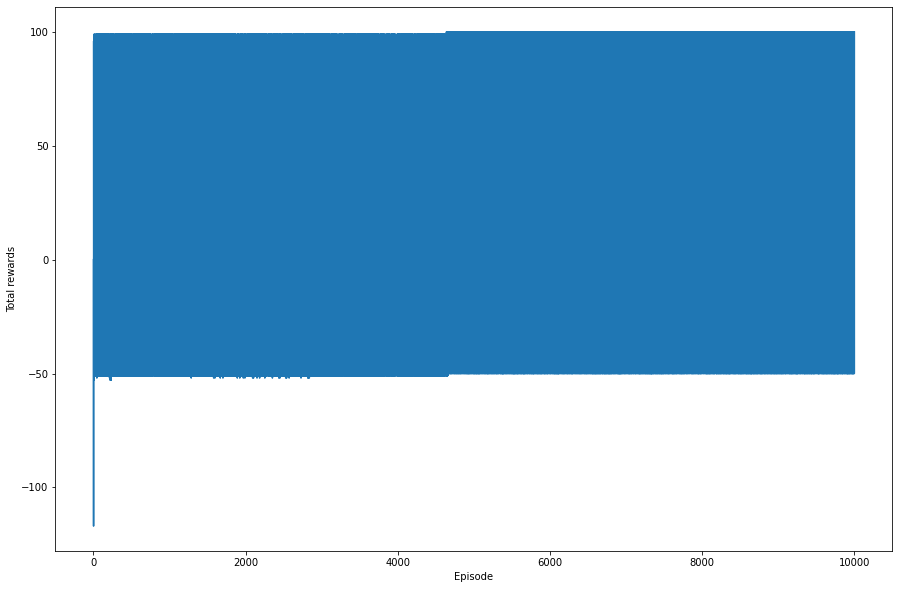

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

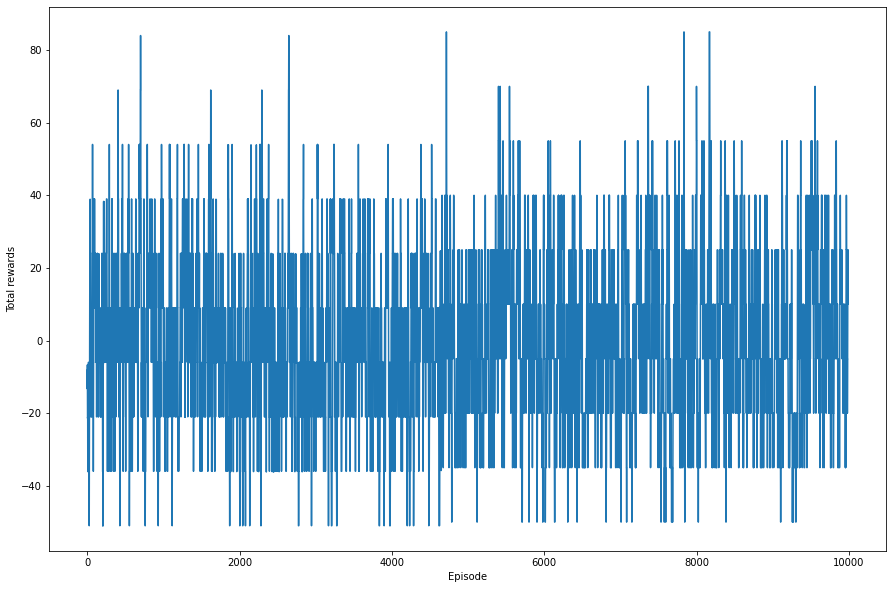

In [12]:
average_number=10
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

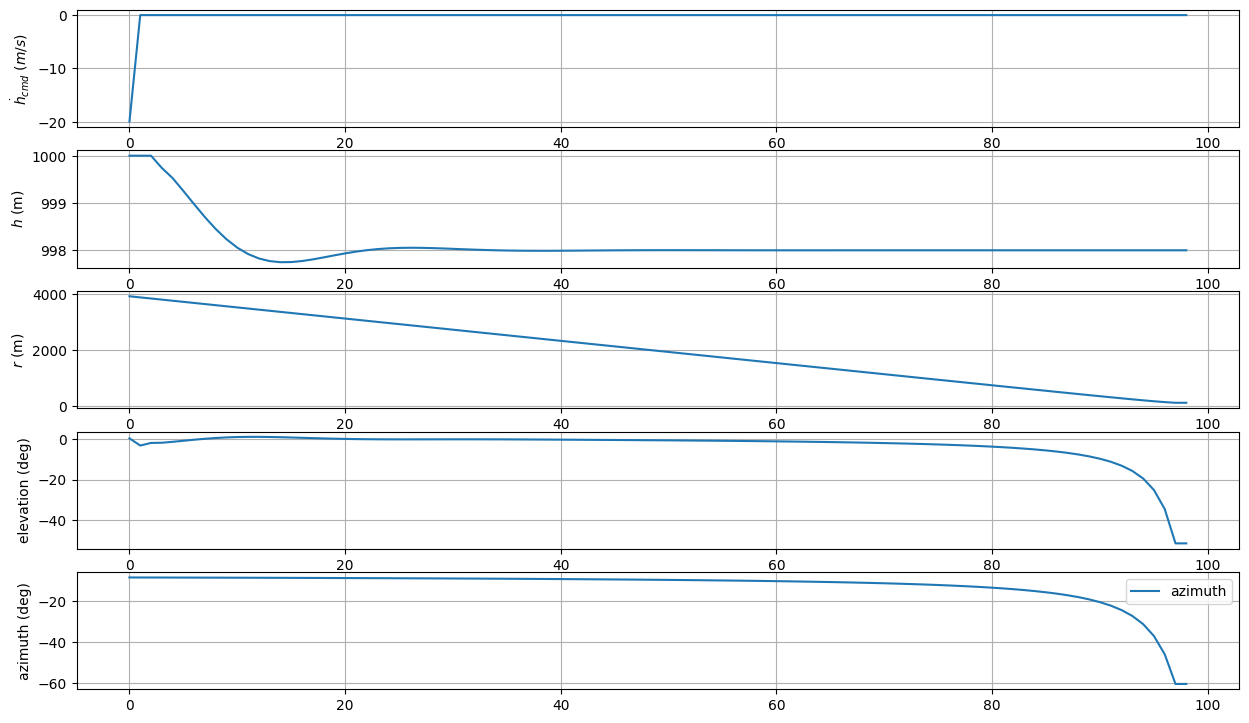

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[99]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

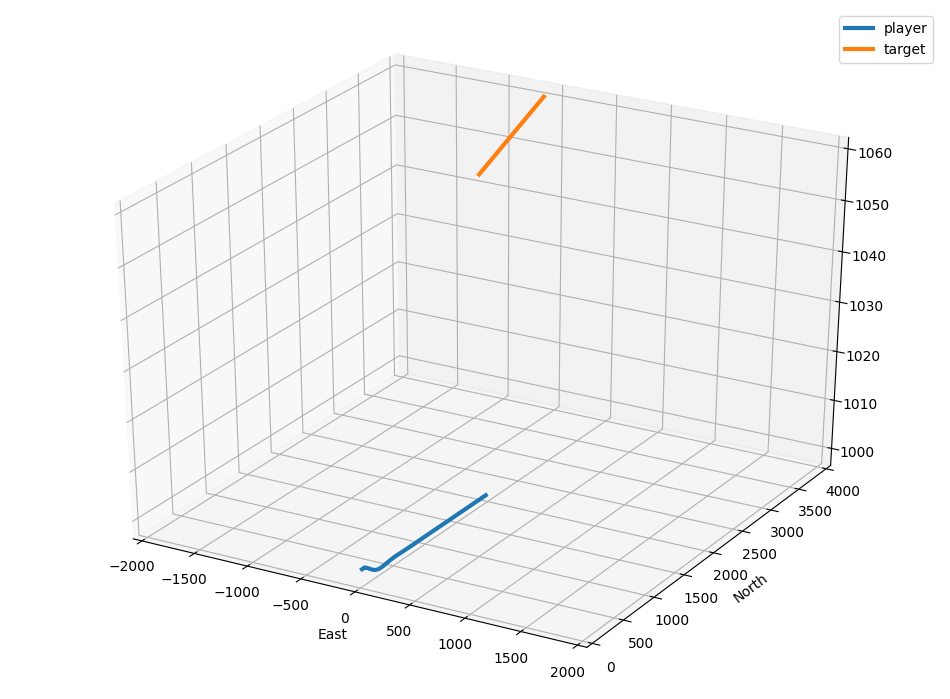

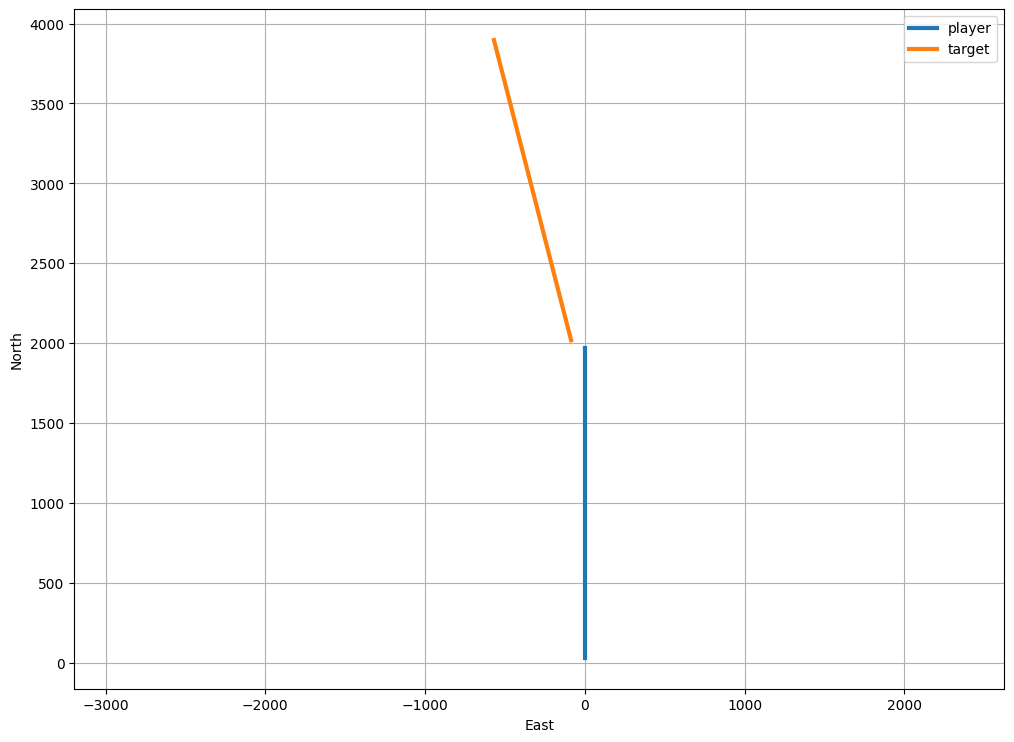

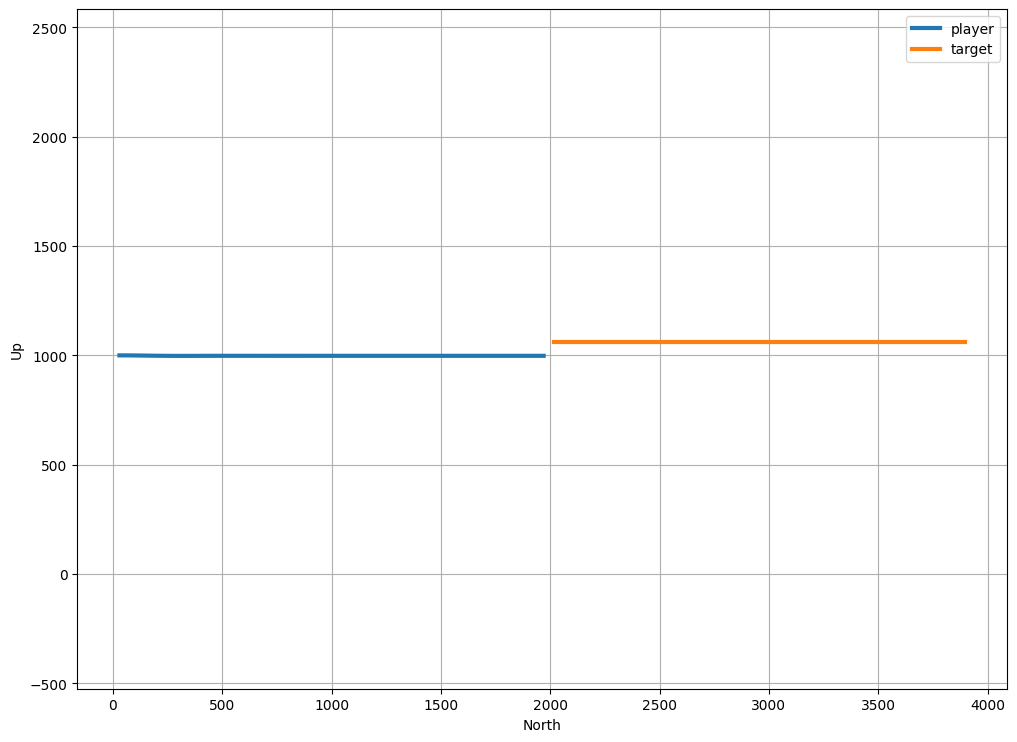

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

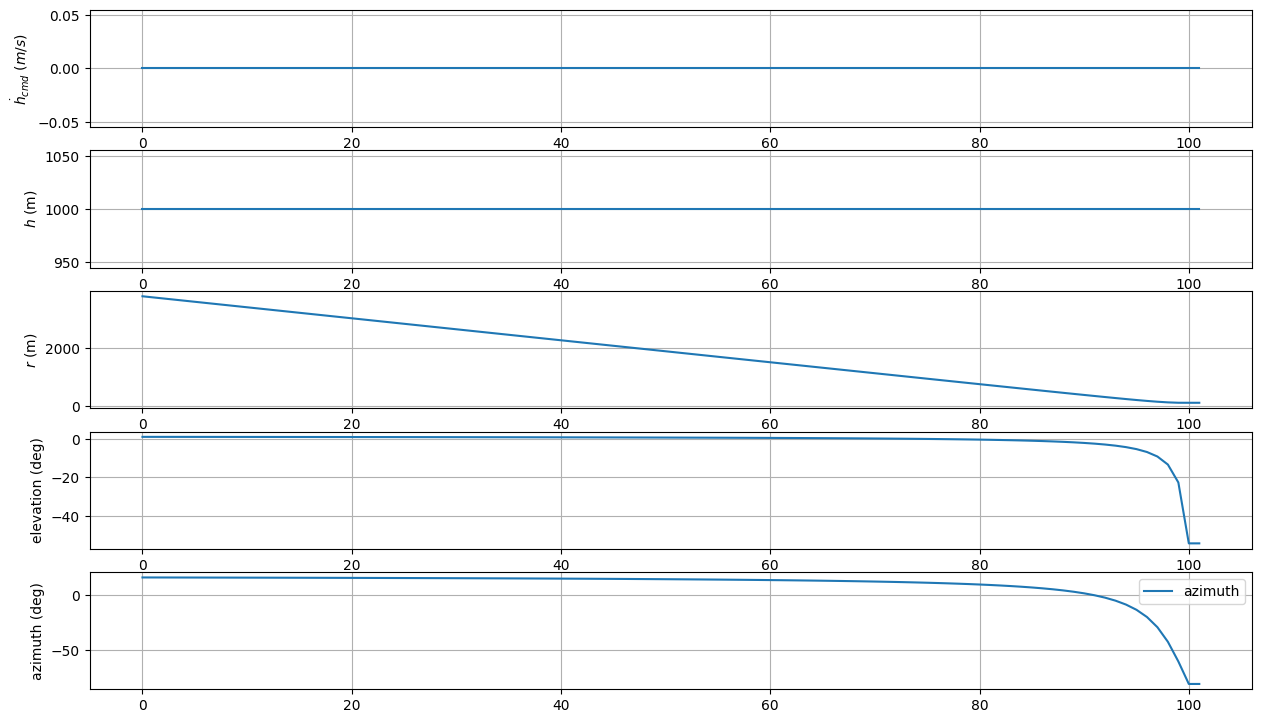

In [22]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[9000]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

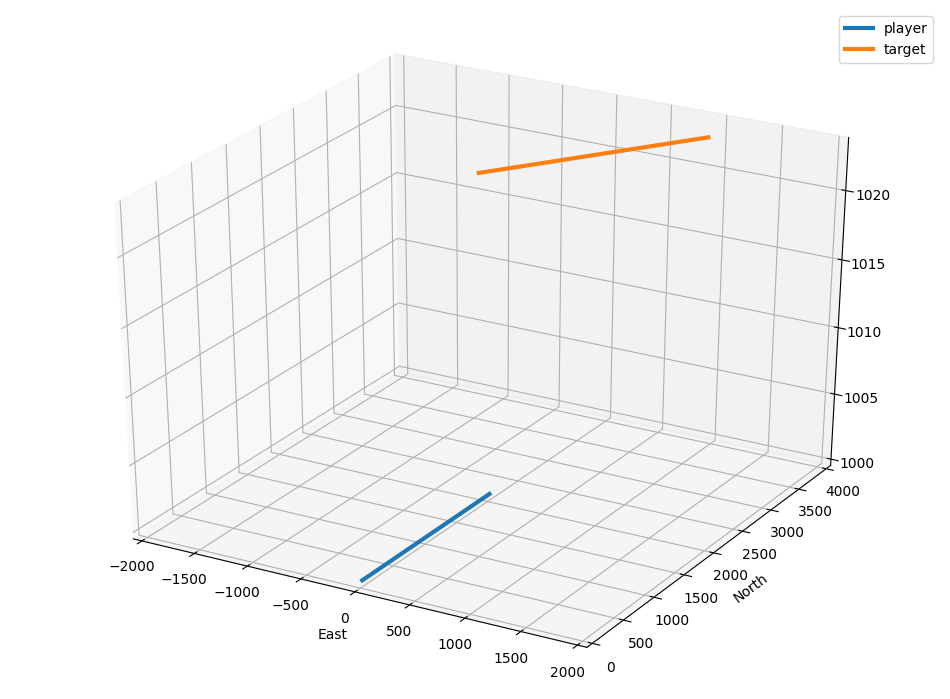

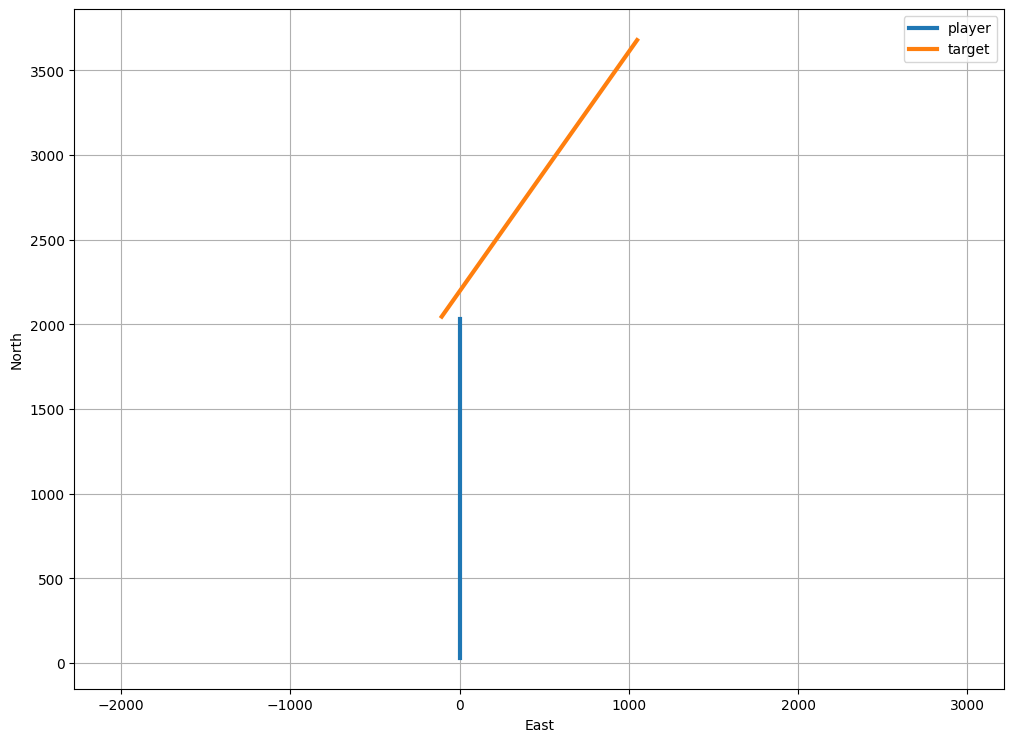

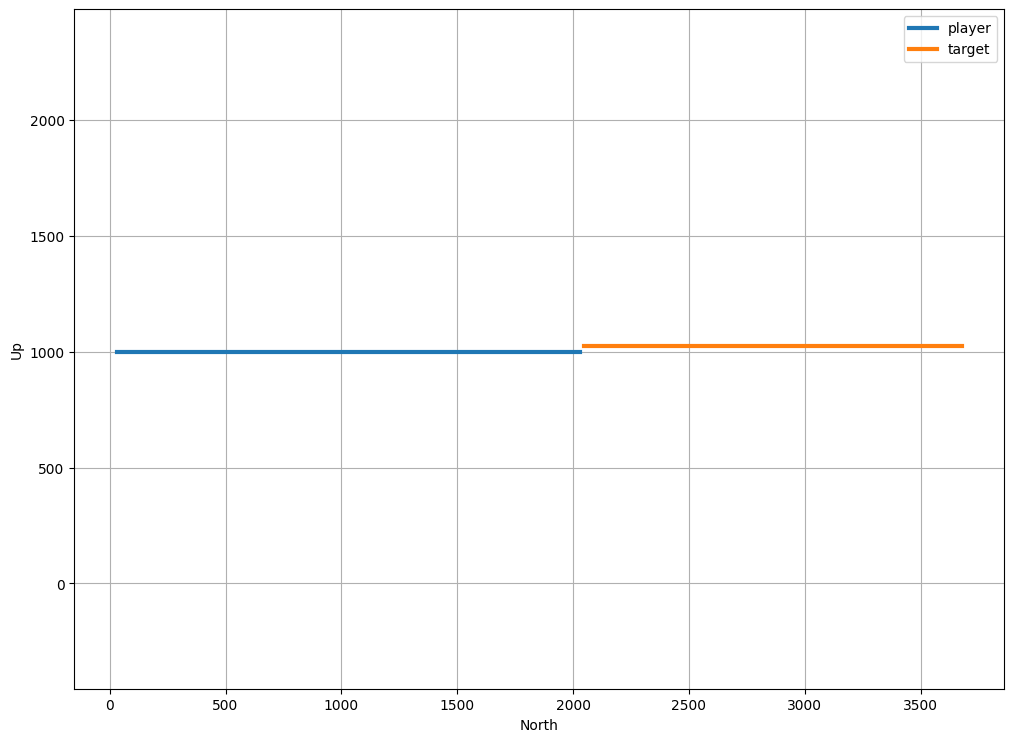

In [31]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [32]:
min(plt_res[:,1])

108.92691670921029

In [33]:
plt_res[:,1]

array([3797.19065738, 3759.08323722, 3720.97613417, 3682.86935806,
       3644.76291916, 3606.65682815, 3568.55109618, 3530.44573487,
       3492.34075635, 3454.2361733 , 3416.13199895, 3378.02824712,
       3339.92493229, 3301.82206957, 3263.71967481, 3225.61776458,
       3187.51635626, 3149.41546807, 3111.31511912, 3073.21532946,
       3035.11612015, 2997.01751333, 2958.91953227, 2920.82220145,
       2882.72554667, 2844.62959507, 2806.53437529, 2768.43991755,
       2730.34625373, 2692.25341755, 2654.16144463, 2616.07037269,
       2577.98024166, 2539.89109387, 2501.80297424, 2463.71593044,
       2425.63001316, 2387.54527631, 2349.46177728, 2311.37957727,
       2273.29874156, 2235.21933988, 2197.14144678, 2159.06514209,
       2120.99051136, 2082.91764637, 2044.84664576, 2006.77761564,
       1968.71067031, 1930.6459331 , 1892.58353724, 1854.52362689,
       1816.46635829, 1778.41190102, 1740.36043952, 1702.31217467,
       1664.26732571, 1626.22613239, 1588.18885738, 1550.15578